In [1]:
%load_ext autoreload
%autoreload 1

import os

import numpy as np
from scipy.special import expit
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import brier_score_loss
from sklearn.calibration import calibration_curve
from statsmodels.nonparametric.smoothers_lowess import lowess
from scipy.special import logit
from scipy.stats import norm
import seaborn as sns
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import GridSearchCV
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from matplotlib.colors import ListedColormap



from utils import get_variables, expit_transform, treatment_assigment, get_potential_outcomes
%aimport utils


# Random variables defintions

In [2]:
amount_of_vars = 4
intercept = 0
mean = 0
std = 1
n = 10000

noise_mean = 1
noise_std = 0

num_of_experiments = 1000


variables, noise = get_variables(mean_=mean, std_=std, n_=n, m_=amount_of_vars, noise_mean_=noise_mean, noise_std_=noise_std )



# Prop model

## $\pi$ model

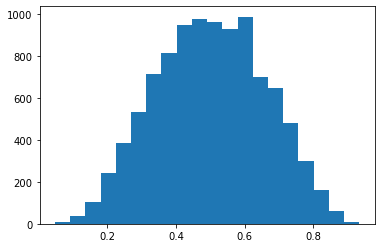

In [3]:
coef = np.array([-0.1, .05, .2, -.05])

exp = expit_transform(coef, variables)
plt.hist(exp, bins=20);

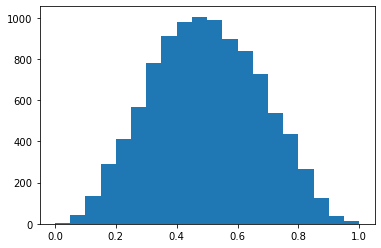

In [4]:

exp2 = (exp - exp.min()) / (exp.max() - exp.min())


plt.hist(exp2, bins=20);

## Treatment assigment

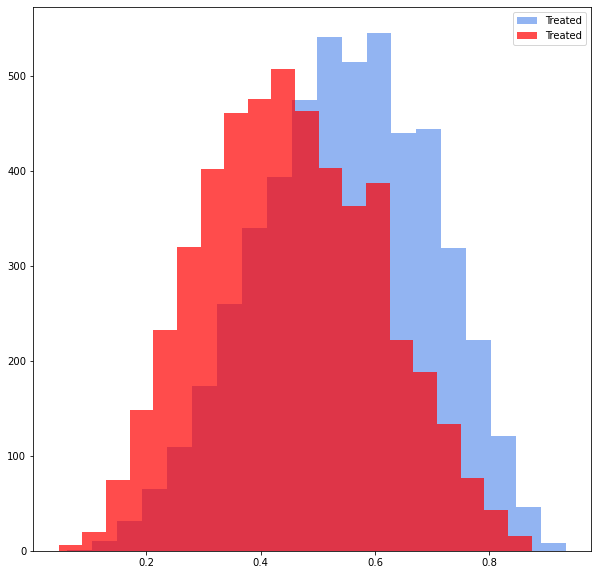

In [4]:



t = treatment_assigment(exp)

fig = plt.figure(figsize=(10, 10))

plt.hist(exp[t == 1], bins=20, color='cornflowerblue', alpha=0.7, label= 'Treated');
plt.hist(exp[t == 0], bins=20, color='red', alpha=0.7, label= 'Treated');

plt.legend();

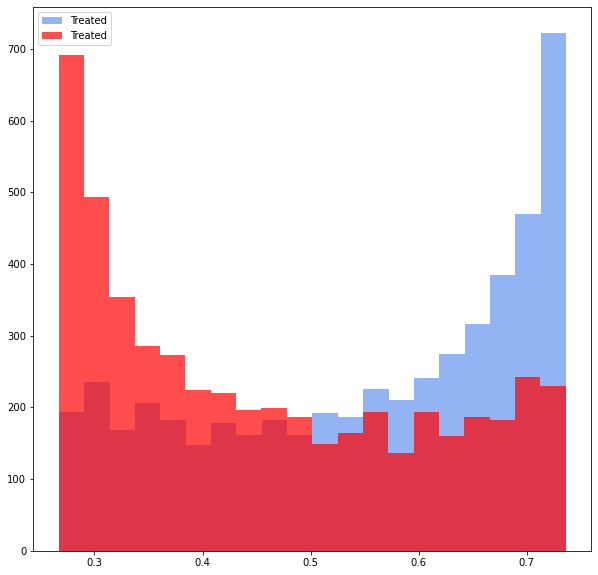

In [647]:
fig = plt.figure(figsize=(10, 10))

plt.hist(exp2[t == 1], bins=20, color='cornflowerblue', alpha=0.7, label= 'Treated');
plt.hist(exp2[t == 0], bins=20, color='red', alpha=0.7, label= 'Treated');

plt.legend();

# Outcome model

In [5]:
y_coef = np.array([5, 1.2, 3.6, 1.2, 1.2, .0])

potential_outcomes_lst = utils.get_potential_outcomes(variables, y_coef, noise)

y = np.where(t == 1, potential_outcomes_lst[1], potential_outcomes_lst[0])


In [6]:
ate = (potential_outcomes_lst[1]  - potential_outcomes_lst[0]).mean()
ate_hat = utils.calc_ipw(y, t, exp)

In [7]:
ate - ate_hat

0.19614412018988858

In [9]:
ate_hat / ate

1.0161609250584063

# Calibration Calculation

In [314]:

err_s = pd.Series(err)
brier_score = brier_score_loss(t, exp)
brier = pd.Series(brier_score, index=['brier'])

calib_res_df = err_s.describe(percentiles=[.1, .5, .9]).append(brier).to_frame().T



In [364]:
ate_hat = utils.calc_ipw(y, t, exp)
utils.generate_calib_error_df(t, exp).assign(ATE=ate_hat)

,count,mean,std,min,10%,50%,90%,max,brier,ATE
0,10000.0,0.019038,0.009125,0.000021,0.005447,0.020683,0.029102,0.052205,0.225334,4.509613


In [1014]:
ate_hat2 = utils.calc_ipw(y, t, exp3)
utils.generate_calib_error_df(t, exp3).assign(ATE=ate_hat2)

,count,mean,std,min,10%,50%,90%,max,brier,ATE
0,10000.0,0.01872,0.009135,0.000003,0.006628,0.019957,0.029867,0.045586,0.224086,4.477231


In [433]:
pd.Series(exp2).describe()

count    10000.000000
mean         0.501465
std          0.108217
min          0.147051
25%          0.426389
50%          0.501699
75%          0.576626
max          0.870538
dtype: float64

## to check calibration methods

In [466]:
# exp2 = expit(exp ** 2)

from scipy.special import logit
from scipy.stats import norm

exp2 = min_max_transform(logit(exp))

exp2 = min_max_transform(np.arctan(logit(exp)))

exp2 = min_max_transform(np.tanh(logit(exp)))

exp2 = utils.expit_transform(coef, variables, exp_scale=0.5)

exp2 = utils.expit_transform(coef, variables, exp_scale=5)


In [467]:
norm.ppf(logit(exp))

array([        nan,         nan, -0.05542964, ...,         nan,
               nan,  0.05772639])

In [477]:
exp2 = norm.cdf(logit(exp)*2)

In [ ]:
expirments = {
    'identity': lambda x: x
    'min_max': lambda x: min_max_transform(logit(x)),
    'min_max_arctan': lambda x: min_max_transform(np.arctan(logit(exp))),
    'min_max_tanh': lambda x: min_max_transform(np.tanh(logit(exp))),
    'scaled_expit_0.5': lambda x: expit(logit(exp)*0.5),
    'scaled_expit_5': lambda x: expit(logit(exp)*5),
    'probit': lambda x: norm.cdf(logit(exp)),
    'scaled_probit_0.5': lambda x: norm.cdf(logit(exp) * 2)
}

In [630]:
exp2 = experiments['scaled_expit_0.25'](exp)

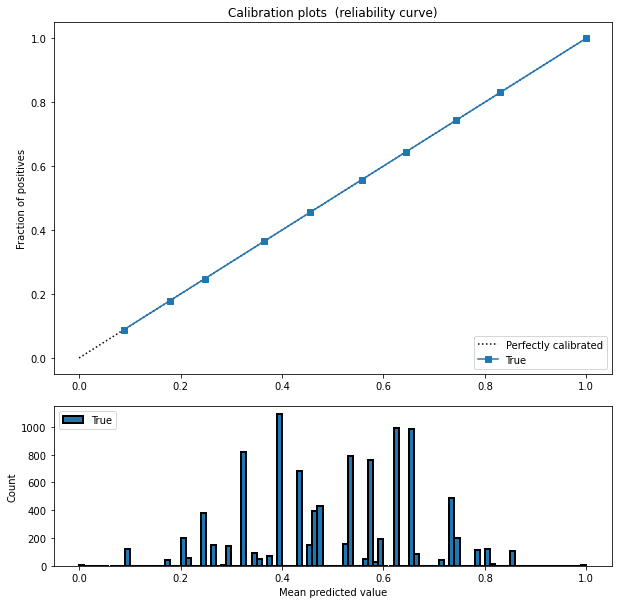

In [1013]:
plt.figure(figsize=(10, 10))
ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
ax2 = plt.subplot2grid((3, 1), (2, 0))

ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")


fraction_of_positives, mean_predicted_value = \
    calibration_curve(t, exp2, n_bins=10)

name = "True"

ax1.plot(mean_predicted_value, fraction_of_positives, "s-",
         label=f"{name}")

ax2.hist(exp2, range=(0, 1), bins=100, label=name, histtype="bar", lw=2, alpha=1, fc=None, edgecolor='black')

ax1.set_ylabel("Fraction of positives")
ax1.set_ylim([-0.05, 1.05])
ax1.legend(loc="lower right")
ax1.set_title('Calibration plots  (reliability curve)')

ax2.set_xlabel("Mean predicted value")
ax2.set_ylabel("Count")
ax2.legend(loc="upper left", ncol=2)

# full simulation

In [875]:
amount_of_vars = 4
intercept = 0
mean = 0
std = 1
n = 10000

noise_mean = 1
noise_std = 0

coef = np.array([-0.1, .05, .2, -.05])
y_coef = np.array([5, 1.2, 3.6, 1.2, 1.2, .0])

# num_of_experiments = 100

# calib_df = utils.generate_simulation(m=amount_of_vars, mean=mean, std=std, n=n, noise_mean=noise_mean,
#                                      noise_std=noise_std, coef=coef, y_coef=y_coef, num_of_experiments=num_of_experiments)

# calib_df['type'] = 'true_prop'
# calib_df

In [483]:
expirments = {
    'identity': lambda x: x,
    'min_max': lambda x: utils.min_max_transform(logit(x)),
    'min_max_arctan': lambda x: utils.min_max_transform(np.arctan(logit(x))),
    'min_max_tanh': lambda x: utils.min_max_transform(np.tanh(logit(x))),
    'scaled_expit_0.5': lambda x: expit(logit(x)*0.5),
    'scaled_expit_5': lambda x: expit(logit(x)*5),
    'probit': lambda x: norm.cdf(logit(x)),
    'scaled_probit_0.5': lambda x: norm.cdf(logit(x) * 2)
}

num_of_experiments = 10


calib_df = utils.generate_simulation(m=amount_of_vars, mean=mean, std=std, n=n, noise_mean=noise_mean,
                                     noise_std=noise_std, coef=coef, y_coef=y_coef, num_of_experiments=num_of_experiments, experiments=expirments)

# calib_df['type'] = 'true_prop'
calib_df

100%|██████████| 10/10 [04:58<00:00, 29.86s/it]


,count,mean,std,min,10%,50%,90%,max,brier,type,ATE
0,10000.0,0.017592,0.010052,1.034629e-05,0.005424,0.013638,0.030995,0.031278,0.225836,identity,5.298871
0,10000.0,0.037248,0.019514,3.651573e-06,0.010456,0.035554,0.064600,0.067636,0.226408,min_max,5.558454
0,10000.0,0.042609,0.025858,6.286795e-07,0.008737,0.041400,0.077685,0.113483,0.230815,min_max_arctan,4.359146
0,10000.0,0.076218,0.043313,7.828786e-06,0.015968,0.076763,0.134405,0.168471,0.237943,min_max_tanh,2.845422
0,10000.0,0.077426,0.046167,7.210562e-07,0.016477,0.075248,0.140561,0.236810,0.230809,scaled_expit_0.5,6.092696
...,...,...,...,...,...,...,...,...,...,...,...
9,10000.0,0.072012,0.038097,2.021944e-05,0.016372,0.074890,0.121673,0.146772,0.235333,min_max_tanh,2.945169
9,10000.0,0.081015,0.050864,1.589878e-05,0.016152,0.076766,0.151047,0.274698,0.230012,scaled_expit_0.5,6.155836
9,10000.0,0.191953,0.071414,2.209576e-04,0.075507,0.221098,0.256576,0.261410,0.281276,scaled_expit_5,-264.806278
9,10000.0,0.042656,0.026152,2.972898e-07,0.007383,0.041623,0.078956,0.108247,0.229404,probit,3.960627


In [1083]:
rf_tuned_parameters = [{'max_depth': [1, 2, 3],
                     'n_estimators': [1, 5, 10, 100, 200, 400, 1000]}]

gb_tuned_parameters = [{'max_depth': [1, 2, 3, 4],
                        'learning_rate': [0.01, 0.05, 0.1],
                     'n_estimators': [1, 3, 5, 10, 15]}]

scores = 'neg_brier_score'

cv_inner = KFold(n_splits=10, shuffle=True, random_state=42)


model_experiments = {
    'lr': LogisticRegression(random_state=42, n_jobs=-1, penalty='none'),
    'lr_l1': LogisticRegressionCV(random_state=42, n_jobs=-1, cv=10, solver='saga', penalty='l1', max_iter=1e4),
    'lr_l2': LogisticRegressionCV(random_state=42, n_jobs=-1, cv=10, solver='saga', penalty='l2', max_iter=1e4),
    'GBT_cv': GridSearchCV(GradientBoostingClassifier(random_state=42), gb_tuned_parameters, scoring=scores, n_jobs=-1, cv=cv_inner),
    'rf_cv': GridSearchCV(RandomForestClassifier(random_state=42, oob_score=True), rf_tuned_parameters, scoring=scores, n_jobs=-1, cv=cv_inner),
}

In [876]:
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression


from sklearn.model_selection import GridSearchCV

tuned_parameters = [{'max_depth': [1,2, 3, 4, 5],
                     'n_estimators': [1, 5, 10, 100]}]

scores = 'neg_brier_score'

model_experiments = {
#     'GBT': GradientBoostingClassifier(random_state=42),
#     'rf': RandomForestClassifier(random_state=42, n_jobs=-1),
    'lr': LogisticRegression(random_state=42, penalty='none', n_jobs=-1),
    'GBT_cv': GridSearchCV(GradientBoostingClassifier(), tuned_parameters, scoring=scores, n_jobs=-1),
    'rf_cv': GridSearchCV(RandomForestClassifier(), tuned_parameters, scoring=scores, n_jobs=-1),
    'lr_l1': LogisticRegressionCV(random_state=42, penalty='l1', n_jobs=-1, cv=10),
    'lr_l2': LogisticRegressionCV(random_state=42, penalty='l2', n_jobs=-1, cv=10),
}

In [1084]:
scaling_range = [0.125, 0.25, 1/3, 0.5, 0.75, 1, 1.25, 1.5, 1.75, 2, 3]

experiments = utils.scaled_for_experiments(scaling_range)

experiments.update(model_experiments)

num_of_experiments = 10


calib_df = utils.generate_simulation(
    m=amount_of_vars, 
    mean=mean, std=std, n=n, 
    noise_mean=noise_mean,
    noise_std=noise_std,
    coef=coef,
    y_coef=y_coef,
    num_of_experiments=num_of_experiments,
    experiments=experiments,
    post_colab_func=utils.sigmoid_calib,
    save=True,
    nested_cv=True
)

calib_df['ATE_error'] = (calib_df['ATE'] - y_coef[0]).pipe(lambda x: np.sqrt(x ** 2))


calib_df

100%|██████████| 10/10 [1:15:28<00:00, 452.82s/it]


,count,mean,std,min,10%,50%,90%,max,brier,type,scale,calibration_type,ATE,Balancing,ATE_error
0,10000.0,0.130339,0.084085,9.647740e-06,0.023180,0.124353,0.245073,0.472271,0.243601,scaled_expit_0.125,0.125,None,6.368819,0.392472,1.368819
0,10000.0,0.020560,0.009326,7.490329e-07,0.005599,0.022747,0.032031,0.036461,0.225187,scaled_expit_0.125_calibrated,0.125,sigmoid_calib,4.769755,0.356361,0.230245
0,10000.0,0.112998,0.071203,1.086602e-05,0.020443,0.109472,0.209792,0.381155,0.238217,scaled_expit_0.25,0.25,None,6.095099,0.390235,1.095099
0,10000.0,0.020459,0.009335,6.177339e-08,0.005552,0.022607,0.032029,0.037294,0.225181,scaled_expit_0.25_calibrated,0.25,sigmoid_calib,4.772934,0.356340,0.227066
0,10000.0,0.101606,0.062849,1.614820e-05,0.018476,0.099604,0.186635,0.329383,0.235195,scaled_expit_0.3333333333333333,0.333333,None,5.926066,0.388038,0.926066
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9,10000.0,0.016975,0.010472,1.819170e-06,0.002553,0.016424,0.030761,0.049573,0.226669,lr_l2_calibrated,lr_l2_model,sigmoid_calib,5.135354,0.348617,0.135354
9,10000.0,0.041209,0.025087,2.726561e-06,0.007138,0.040351,0.075776,0.105804,0.229409,GBT_cv,GBT_cv_model,None,5.625164,0.362511,0.625164
9,10000.0,0.016342,0.009977,2.222802e-05,0.002799,0.015724,0.030526,0.041383,0.228526,GBT_cv_calibrated,GBT_cv_model,sigmoid_calib,5.376166,0.352297,0.376166
9,10000.0,0.047277,0.033481,5.223622e-06,0.006397,0.043248,0.097520,0.138545,0.229943,rf_cv,rf_cv_model,None,5.789058,0.361217,0.789058


In [803]:
cm = sns.diverging_palette(240, 50, s=80, l=70,
                           n=calib_df['scale'].nunique(),
                           as_cmap=True, 
                           center='light'
                          )


# calib_df['scale'].apply(np.log).map(cm)

# sns.diverging_palette(240, 500, s=60, n=8)

cm

In [832]:
calib_df.to_csv('calib_df_before_smd.csv')

In [967]:
sns.diverging_palette(240, 18, s=80, l=50,sep=1,
                           n=calib_df['scale'].nunique(),
                      center='light'
#                            as_cmap=True, 
                          )

[(0.23010319520718325, 0.4887423024302338, 0.6690987262229071),
 (0.36965431696031037, 0.5783810431367898, 0.7244487514404696),
 (0.5147874835835626, 0.6716053334716081, 0.7820127776667346),
 (0.6571187253403653, 0.7630298459656776, 0.8384654791679281),
 (0.8022518919636176, 0.8562541363004958, 0.8960295053941931),
 (0.9502644313749016, 0.9458084295205358, 0.9453810551713931),
 (0.9210472029754666, 0.8188485935522556, 0.7979827102009093),
 (0.8897677231370339, 0.688549926764675, 0.6464475798844067),
 (0.8590921214775731, 0.5607667916300699, 0.497837970037506),
 (0.8278126416391404, 0.4304681248424893, 0.3463028397210033),
 (0.7977362187175703, 0.30518094523904643, 0.20059598364744313)]

In [971]:
sns.diverging_palette(240, 18, s=80, l=50,sep=1,
                           n=calib_df['scale'].nunique(),
                      center='light'
#                            as_cmap=True, 
                          )

[(0.23010319520718325, 0.4887423024302338, 0.6690987262229071),
 (0.36965431696031037, 0.5783810431367898, 0.7244487514404696),
 (0.5147874835835626, 0.6716053334716081, 0.7820127776667346),
 (0.6571187253403653, 0.7630298459656776, 0.8384654791679281),
 (0.8022518919636176, 0.8562541363004958, 0.8960295053941931),
 (0.9502644313749016, 0.9458084295205358, 0.9453810551713931),
 (0.9210472029754666, 0.8188485935522556, 0.7979827102009093),
 (0.8897677231370339, 0.688549926764675, 0.6464475798844067),
 (0.8590921214775731, 0.5607667916300699, 0.497837970037506),
 (0.8278126416391404, 0.4304681248424893, 0.3463028397210033),
 (0.7977362187175703, 0.30518094523904643, 0.20059598364744313)]

In [1086]:
model_rows = pd.to_numeric(calib_df['scale'], errors='coerce').isna()

In [708]:
calib_df['calibration_type_temp'] = calib_df['calibration_type'].fillna('None')

In [1087]:
calib_df[~model_rows].sort_values('scale').groupby('type')['scale'].max().rank(method='first')

type
scaled_expit_0.125                             1.0
scaled_expit_0.125_calibrated                  2.0
scaled_expit_0.25                              3.0
scaled_expit_0.25_calibrated                   4.0
scaled_expit_0.3333333333333333                5.0
scaled_expit_0.3333333333333333_calibrated     6.0
scaled_expit_0.5                               7.0
scaled_expit_0.5_calibrated                    8.0
scaled_expit_0.75                              9.0
scaled_expit_0.75_calibrated                  10.0
scaled_expit_1                                11.0
scaled_expit_1.25                             13.0
scaled_expit_1.25_calibrated                  14.0
scaled_expit_1.5                              15.0
scaled_expit_1.5_calibrated                   16.0
scaled_expit_1.75                             17.0
scaled_expit_1.75_calibrated                  18.0
scaled_expit_1_calibrated                     12.0
scaled_expit_2                                19.0
scaled_expit_2_calibrated 

In [810]:
# [cm[i] for i in range(cm)]

# np.dot(cm(-np.inf), 256)
calib_df[model_rows]

,count,mean,std,min,10%,50%,90%,max,brier,type,scale,calibration_type,ATE,ATE_error
0,10000.0,0.020009,0.008795,2.497761e-06,0.006793,0.021683,0.030375,0.047240,0.223982,lr,lr_model,None,5.063001,0.063001
0,10000.0,0.018869,0.010209,3.049955e-06,0.005143,0.019659,0.031515,0.059211,0.224001,lr_calibrated,lr_model,sigmoid_calib,5.075126,0.075126
0,10000.0,0.044860,0.026270,3.612241e-07,0.010858,0.042426,0.080833,0.138204,0.222851,GBT_cv,GBT_cv_model,None,5.446718,0.446718
0,10000.0,0.020308,0.013564,4.005693e-06,0.004106,0.017590,0.039478,0.069323,0.222154,GBT_cv_calibrated,GBT_cv_model,sigmoid_calib,5.270301,0.270301
0,10000.0,0.051410,0.036528,3.773774e-06,0.007712,0.045620,0.102979,0.182215,0.217956,rf_cv,rf_cv_model,None,5.390347,0.390347
0,10000.0,0.020915,0.019212,9.130779e-08,0.002659,0.014491,0.049948,0.091858,0.217073,rf_cv_calibrated,rf_cv_model,sigmoid_calib,5.185138,0.185138
1,10000.0,0.015696,0.012739,2.439854e-06,0.003683,0.013069,0.031298,0.096531,0.225847,lr,lr_model,None,5.028591,0.028591
1,10000.0,0.015578,0.014023,9.411559e-07,0.003434,0.010290,0.033486,0.092446,0.226038,lr_calibrated,lr_model,sigmoid_calib,5.044595,0.044595
1,10000.0,0.037146,0.026477,1.012895e-05,0.005323,0.033029,0.075216,0.130470,0.219909,GBT_cv,GBT_cv_model,None,5.219147,0.219147
1,10000.0,0.014157,0.013983,4.984660e-06,0.001687,0.008306,0.035683,0.065440,0.219491,GBT_cv_calibrated,GBT_cv_model,sigmoid_calib,4.950571,0.049429


In [717]:
hue_s = calib_df.sort_values('scale').groupby('type')['scale'].max().apply(np.log).map(cm)

# sns.relplot(x='mean', y='ATE_error', data=calib_df, hue='type', col='calibration_type_temp', kind="scatter")


Text(0, 0.5, 'ATE Error')

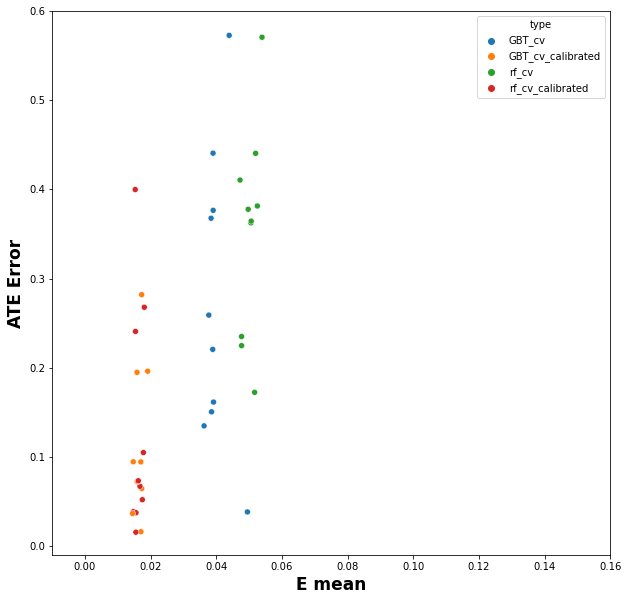

In [880]:
plt.figure(figsize=(10,10))
sns.scatterplot(x='mean', y='ATE_error', data=calib_df[model_rows].loc[lambda df: df['type'].str.contains('cv')], hue='type')
plt.ylim(-0.01, 0.6)
plt.xlim(-.01, 0.16)

plt.xlabel('E mean', fontdict={'weight': 'bold', 'size':17})
plt.ylabel('ATE Error', fontdict={'weight': 'bold', 'size':17})


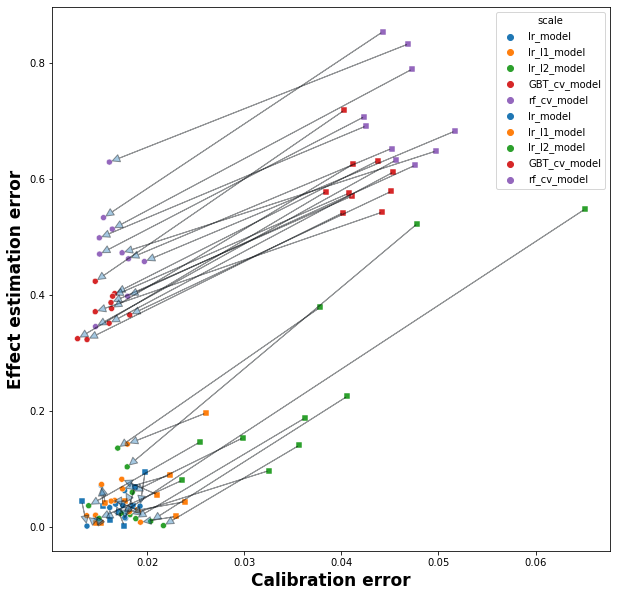

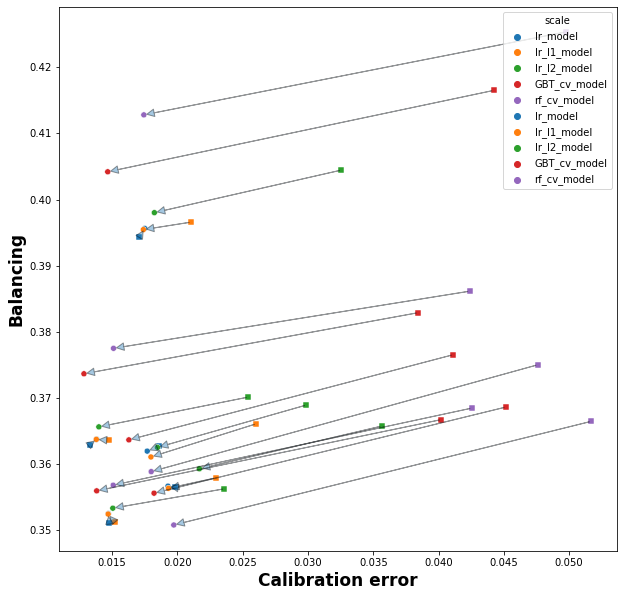

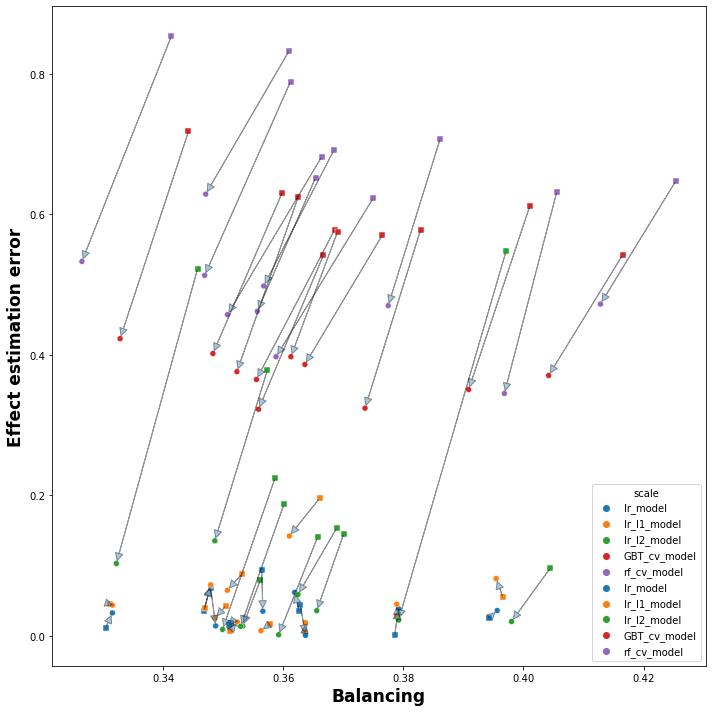

In [1092]:
plot_comp_plot(calib_df[model_rows])
# plt.savefig('simulation_models_calibration_ate.jpg', dpi=400)

plot_comp_plot(calib_df[model_rows].loc[:4], y_metric='Balancing', y_label='Balancing')
# plt.savefig('simulation_models_calibration_balancing.jpg', dpi=400)

plot_comp_plot(calib_df[model_rows], metric='Balancing', x_label='Balancing')
plt.tight_layout()
# plt.savefig('simulation_models_balancing_ate.jpg', dpi=400)

0     True
0    False
0     True
0    False
0     True
     ...  
4    False
4     True
4    False
4     True
4    False
Name: calibration_type, Length: 70, dtype: bool

In [840]:
temp_scale_df = calib_df[~model_rows].copy()

temp_scale_df['scale'] = temp_scale_df['scale'].astype('float64')

In [976]:
def plot_comp_simulation_plot(big_df, metric='mean', y_metric='ATE_error', x_label='Calibration error', y_label='Effect estimation error', cm=None):
    fig = plt.figure(figsize=(10,10))
    if cm is not None:
        hue_norm, _, palette = utils.get_palette_for_values(cm, big_df)
        hue_order = big_df['scale'].sort_values().unique()
        palette = ListedColormap(palette, name='temp')
    else:
        hue_order = None
        palette = None
    for type_, marker in zip(['model', 'calibrated'], ['s', 'o']):
        mask = big_df['calibration_type'].isna() if type_ == 'model' else ~big_df['calibration_type'].isna()
        temp_df = big_df.loc[mask]
        legend = 'full' if type_ == 'model' else False
#         print(palette, hue_order)
#         print(type(palette))
        ax = sns.scatterplot(x=metric, y=y_metric, data=temp_df.sort_values('scale'), hue='scale', marker=marker, legend=legend, s=40,
                            hue_order=hue_order, palette=palette, edgecolor='black')
    temp_df = big_df
#     print(temp_df['scale'].unique())
    plt.xlabel(x_label, fontdict={'weight': 'bold', 'size':17})
    plt.ylabel(y_label, fontdict={'weight': 'bold', 'size':17})

    arrows = utils.get_arrows(temp_df, calib_metric=metric, y_metric=y_metric)

    arrows.apply(utils.plot_arrow, ax=ax);
    legend_elements = [
# Patch(facecolor=lr_colors, edgecolor='w',
#                          label='LR'),
#                    Patch(facecolor=gbt_color, edgecolor='w',
#                          label='GBT'),
#                    Patch(facecolor=rf_color, edgecolor='w',
#                          label='RF'),
                   Line2D([0], [0], marker='s', color='w', markeredgecolor='black', lw=4, alpha=1, label='Uncalibrated', 
                         markerfacecolor='w', markersize=9),
                   Line2D([0], [0], marker='o', color='w', markeredgecolor='black', lw=4, alpha=1, label='Calibrated',
                          markerfacecolor='w', markersize=9),
                  ]
    plt.legend(handles=legend_elements, prop={'weight':'bold', 'size':10})#, title='Deformation', )
    if cm is not None:
        sm = plt.cm.ScalarMappable(cmap=cm, norm=hue_norm)
        sm.set_array([])

        # Remove the legend and add a colorbar
        # ax.get_legend().remove()
        ax.figure.colorbar(sm)

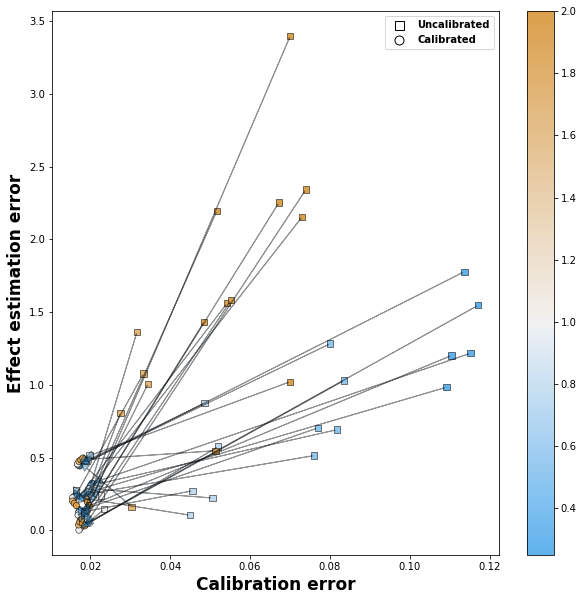

In [978]:

plot_comp_simulation_plot(temp_scale_df.loc[:4].query('scale in [0.25, 0.5, 0.75, 1, 1.5, 1.75, 2]'), cm=cm)
plt.savefig('simulation_calibration_ate.jpg', dpi=400)
# print(palette)

# isinstance(sns.color_palette(palette, as_cmap=True), Colormap)

In [982]:
scale_list = [0.25, 0.5, 0.75, 1, 1.5, 1.75, 2]

display(get_slopes(temp_scale_df.loc[:4].query('scale in @scale_list')))
display(get_slopes(temp_scale_df.loc[:4].query('scale in @scale_list'),x_metric='mean', y_metric='Balancing'))
display(get_slopes(temp_scale_df.loc[:4].query('scale in @scale_list'),x_metric='Balancing'))

0                                                                    \
      count       mean        std        min        25%        50%        75%   
scale                                                                           
0.25    5.0 -11.597914   2.999526 -15.273081 -13.858954 -11.387790  -9.417259   
0.50    5.0  -9.801525   4.515373 -15.274613 -13.303551  -9.550381  -6.220117   
0.75    5.0  -5.696915   9.100486 -16.244335 -13.351162  -5.308797   2.063565   
1.00    5.0 -29.261486  27.133910 -63.420151 -47.485111 -22.695138 -19.646635   
1.50    5.0 -49.036303  43.772852 -90.892326 -73.429873 -55.174166 -49.309219   
1.75    5.0 -36.977235  21.909286 -61.805109 -44.222043 -41.104343 -35.890732   
2.00    5.0 -39.020292  19.452453 -64.116459 -44.054272 -41.721067 -35.098912   

                  
             max  
scale             
0.25   -8.052485  
0.50   -4.658964  
0.75    4.356151  
1.00    6.939607  
1.50   23.624067  
1.75   -1.863945  
2.00  -10.110748

0                                                              \
      count      mean       std       min       25%       50%       75%   
scale                                                                     
0.25    5.0 -0.340691  0.042316 -0.386887 -0.367283 -0.347772 -0.324015   
0.50    5.0 -0.412842  0.041589 -0.453739 -0.443501 -0.422320 -0.393922   
0.75    5.0 -0.471606  0.040805 -0.513505 -0.501700 -0.483223 -0.443379   
1.00    5.0  0.047576  0.897949 -0.589002 -0.420559 -0.285647 -0.086685   
1.50    5.0  2.227141  0.466124  1.567637  2.006279  2.343405  2.409297   
1.75    5.0  1.349824  0.142334  1.106286  1.353793  1.401205  1.417829   
2.00    5.0  1.169448  0.097575  0.998010  1.188975  1.209722  1.210138   

                 
            max  
scale            
0.25  -0.277499  
0.50  -0.350728  
0.75  -0.416223  
1.00   1.619775  
1.50   2.809088  
1.75   1.470009  
2.00   1.240394

0                                                           \
      count       mean         std         min        25%        50%   
scale                                                                  
0.25    5.0 -33.833481    6.748590  -43.916968 -37.733697 -29.434430   
0.50    5.0 -23.257423    9.646553  -36.168350 -29.996644 -21.048193   
0.75    5.0 -11.015648   18.990307  -33.616668 -26.000038 -10.581619   
1.00    5.0 -39.994366  114.662101 -222.023163 -53.964213 -33.355828   
1.50    5.0  22.547984   18.786813  -10.081086  26.140110  27.500744   
1.75    5.0  27.561877   15.676914    1.330245  30.082848  30.362355   
2.00    5.0  33.426236   15.983653    8.355039  35.089938  35.168885   

                             
             75%        max  
scale                        
0.25  -29.064260 -29.018051  
0.50  -15.790220 -13.283707  
0.75    4.654177  10.465907  
1.00   29.315876  80.055498  
1.50   31.454484  37.725669  
1.75   32.442552  43.591384  
2.00   35.516340  53.000978

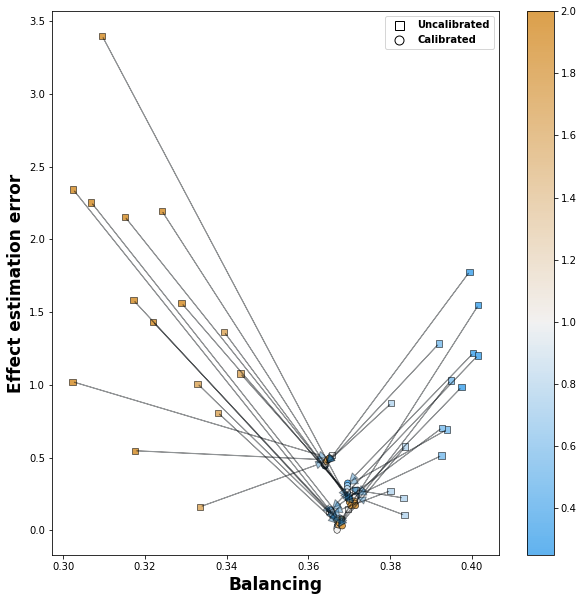

In [981]:
plot_comp_simulation_plot(temp_scale_df.loc[:4].query('scale in [0.25, 0.5, 0.75, 1, 1.5, 1.75, 2]'), cm=cm, metric='Balancing', x_label='Balancing')
plt.savefig('simulation_balancing_ate.jpg', dpi=400)


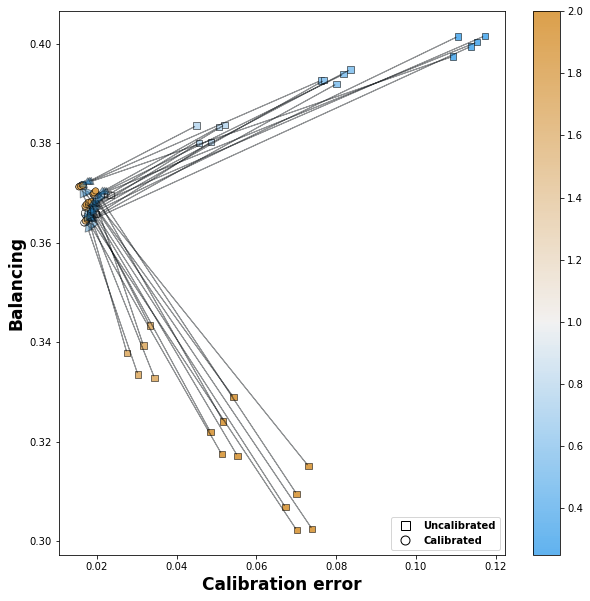

In [984]:
plot_comp_simulation_plot(temp_scale_df.loc[:4].query('scale in [0.25, 0.5, 0.75, 1, 1.5, 1.75, 2]'), cm=cm, y_metric='Balancing', y_label='Balancing')
plt.savefig('simulation_balancing_calibration.jpg', dpi=400)


In [986]:
calib_df.to_csv('new_simulation.csv')

/Users/romg/opt/anaconda3/lib/python3.8/site-packages/seaborn/_core.py:163: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if palette in QUAL_PALETTES:


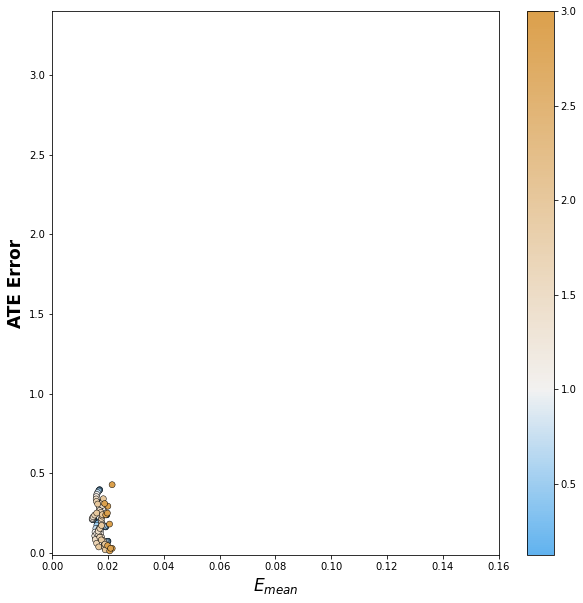

In [812]:
temp_df = temp_scale_df.loc[temp_scale_df['type'].str.contains('calibrated')]

utils.plot_calibration(df=temp_df,
                       calib_metric="mean",
                       calib_metric_label=r"$E_{mean}$",
                       upper_y_bound=3.4,
                       upper_x_bound=0.16,
                       lower_x_bound=0,
                       cm=cm
                      )


# arrows = get_arrows(temp_df, calib_metric='mean')

# arrows.apply(plot_arrow);

[[0.37745744 0.69985334 0.93680394 1.        ]
 [0.45704968 0.73447245 0.93871412 1.        ]
 [0.51011117 0.75755185 0.93998758 1.        ]
 [0.61623416 0.80371067 0.94253449 1.        ]
 [0.78204269 0.87583006 0.94651382 1.        ]
 [0.95031541 0.94606569 0.94266636 1.        ]
 [0.93962528 0.90369375 0.85750488 1.        ]
 [0.92827013 0.86399447 0.77712757 1.        ]
 [0.91691498 0.82429519 0.69675027 1.        ]
 [0.9052937  0.78366546 0.61448912 1.        ]
 [0.86049546 0.62704425 0.29738534 1.        ]] ['scaled_expit_0.125_calibrated', 'scaled_expit_0.25_calibrated', 'scaled_expit_0.3333333333333333_calibrated', 'scaled_expit_0.5_calibrated', 'scaled_expit_0.75_calibrated', 'scaled_expit_1_calibrated', 'scaled_expit_1.25_calibrated', 'scaled_expit_1.5_calibrated', 'scaled_expit_1.75_calibrated', 'scaled_expit_2_calibrated', 'scaled_expit_3_calibrated']


/Users/romg/opt/anaconda3/lib/python3.8/site-packages/seaborn/_core.py:163: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if palette in QUAL_PALETTES:


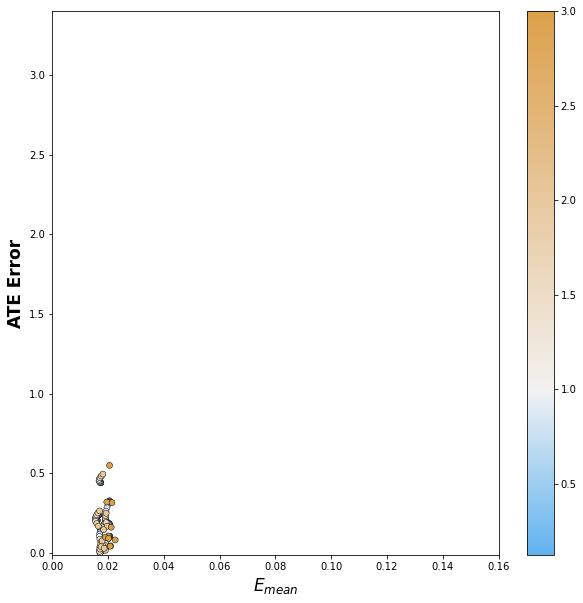

In [927]:
temp_df = temp_scale_df.loc[temp_scale_df['type'].str.contains('calibrated')]

utils.plot_calibration(df=temp_df,
                       calib_metric="mean",
                       calib_metric_label=r"$E_{mean}$",
                       upper_y_bound=3.4,
                       upper_x_bound=0.16,
                       lower_x_bound=0,
                       cm=cm
                      )


# arrows = get_arrows(temp_df, calib_metric='mean')

# arrows.apply(plot_arrow);

/Users/romg/opt/anaconda3/lib/python3.8/site-packages/seaborn/_core.py:163: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if palette in QUAL_PALETTES:


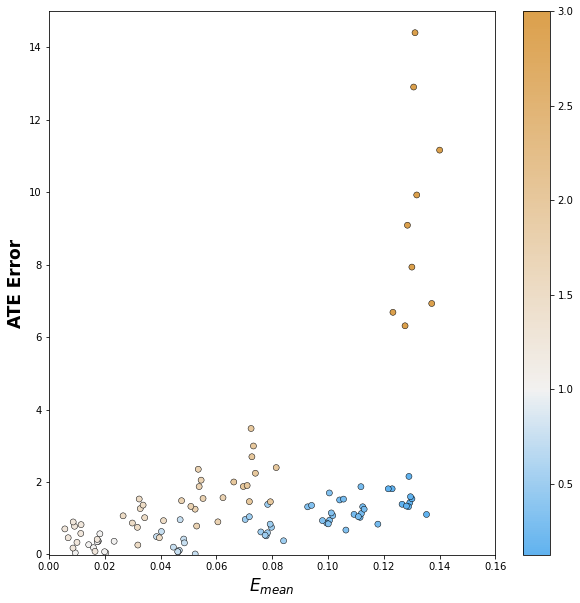

In [117]:
utils.plot_calibration(df=temp_scale_df.loc[~temp_scale_df['type'].str.contains('calibrated')],
                       calib_metric="mean",
                       calib_metric_label=r"$E_{mean}$",
                       upper_y_bound=15,
                       upper_x_bound=0.16,
                       cm=cm
                      )
# plt.legend(loc=2)

In [1004]:
calib_df.sort_values('ATE_error').head(40)

,count,mean,std,min,10%,50%,90%,max,brier,type,scale,calibration_type,ATE,ATE_error
8,10000.0,0.020955,0.016080,2.726291e-06,0.001643,0.018137,0.043122,0.054005,0.225234,scaled_expit_3_calibrated,3.000000,sigmoid_calib,4.975830,0.024170
9,10000.0,0.019516,0.015764,3.625387e-07,0.002399,0.014568,0.043289,0.057435,0.227669,scaled_expit_3_calibrated,3.000000,sigmoid_calib,5.025480,0.025480
1,10000.0,0.003815,0.003569,3.875845e-09,0.000473,0.003625,0.008254,0.022287,0.223169,scaled_expit_1.25,1.250000,None,5.031781,0.031781
9,10000.0,0.017043,0.016795,1.147093e-06,0.001549,0.010205,0.042177,0.074751,0.226690,scaled_expit_2_calibrated,2.000000,sigmoid_calib,4.941473,0.058527
7,10000.0,0.011386,0.007903,3.011267e-06,0.003285,0.009549,0.023909,0.035933,0.226565,scaled_expit_1.25,1.250000,None,4.926085,0.073915
9,10000.0,0.016235,0.016880,2.754845e-06,0.001066,0.008914,0.041377,0.080353,0.226466,scaled_expit_1.75_calibrated,1.750000,sigmoid_calib,4.920879,0.079121
4,10000.0,0.014160,0.010000,5.796162e-07,0.003297,0.011514,0.028351,0.062276,0.226968,scaled_expit_1.25,1.250000,None,5.089709,0.089709
9,10000.0,0.015477,0.016755,8.214794e-08,0.000898,0.007650,0.040212,0.086089,0.226263,scaled_expit_1.5_calibrated,1.500000,sigmoid_calib,4.901073,0.098927
8,10000.0,0.018246,0.015594,2.063008e-06,0.003270,0.013288,0.041412,0.063264,0.224484,scaled_expit_2_calibrated,2.000000,sigmoid_calib,4.889665,0.110335
9,10000.0,0.014974,0.016327,8.542291e-07,0.002012,0.006487,0.038708,0.091478,0.226091,scaled_expit_1.25_calibrated,1.250000,sigmoid_calib,4.882341,0.117659


In [983]:
calib_df.query('scale == 1').sort_values('ATE_error')

,count,mean,std,min,10%,50%,90%,max,brier,type,scale,calibration_type,ATE,ATE_error
9,10000.0,0.014619,0.015807,1.558731e-06,0.003278,0.005532,0.036849,0.095783,0.225954,scaled_expit_1_calibrated,1.0,sigmoid_calib,4.864907,0.135093
8,10000.0,0.019575,0.010491,1.279869e-05,0.004615,0.021130,0.029022,0.056227,0.224022,scaled_expit_1,1.0,None,4.809583,0.190417
8,10000.0,0.017401,0.012664,4.455075e-06,0.003129,0.015350,0.034263,0.067481,0.224046,scaled_expit_1_calibrated,1.0,sigmoid_calib,4.807543,0.192457
2,10000.0,0.016380,0.011937,8.814485e-06,0.004649,0.010541,0.035170,0.064429,0.225198,scaled_expit_1_calibrated,1.0,sigmoid_calib,5.213307,0.213307
7,10000.0,0.015703,0.013536,8.396054e-07,0.002080,0.011952,0.036323,0.062236,0.225509,scaled_expit_1_calibrated,1.0,sigmoid_calib,5.223533,0.223533
3,10000.0,0.016073,0.007844,1.290228e-05,0.004570,0.017783,0.024871,0.043677,0.225500,scaled_expit_1,1.0,None,5.223782,0.223782
2,10000.0,0.018110,0.009168,7.683204e-06,0.005570,0.018035,0.030610,0.052699,0.225074,scaled_expit_1,1.0,None,5.230960,0.230960
7,10000.0,0.015250,0.011137,6.367909e-06,0.002159,0.012916,0.032113,0.045475,0.225490,scaled_expit_1,1.0,None,5.240575,0.240575
9,10000.0,0.011527,0.014999,4.086120e-07,0.000690,0.004837,0.033689,0.093810,0.225777,scaled_expit_1,1.0,None,4.738197,0.261803
6,10000.0,0.019745,0.014656,3.269082e-06,0.006918,0.013927,0.044655,0.082325,0.224563,scaled_expit_1,1.0,None,5.263485,0.263485


In [326]:
def min_max_transform(arr):
    return (arr - arr.min()) / (arr.max() - arr.min())

calib_df_min_max = utils.generate_simulation(m=amount_of_vars, mean=mean, std=std, n=n, noise_mean=noise_mean,
                                     noise_std=noise_std, coef=coef, y_coef=y_coef, num_of_experiments=num_of_experiments, prop_func=min_max_transform)

calib_df_min_max['type'] = 'min_max'
calib_df_min_max

100%|██████████| 100/100 [06:21<00:00,  3.81s/it]


,count,mean,std,min,10%,50%,90%,max,brier,ATE
0,10000.0,0.007169,0.007015,1.599103e-06,0.001566,0.004726,0.017724,0.043717,0.225639,4.467960
1,10000.0,0.006022,0.005233,8.987875e-07,0.000831,0.003135,0.013660,0.023615,0.225555,5.003496
2,10000.0,0.020164,0.008352,1.067833e-05,0.005727,0.023684,0.027738,0.040211,0.223200,4.577017
3,10000.0,0.015027,0.009676,1.638426e-03,0.002397,0.014672,0.028179,0.034149,0.222593,4.980606
4,10000.0,0.004855,0.004112,1.769438e-06,0.001512,0.004029,0.010134,0.029789,0.225033,-20047.416128
...,...,...,...,...,...,...,...,...,...,...
95,10000.0,0.004993,0.003806,9.376297e-07,0.000846,0.003973,0.010508,0.032536,0.224681,4.701124
96,10000.0,0.012173,0.006196,6.448165e-07,0.004817,0.012120,0.019435,0.049328,0.226774,4.213132
97,10000.0,0.012093,0.004361,1.022760e-05,0.004477,0.014258,0.016088,0.016408,0.220701,4.874188
98,10000.0,0.013602,0.006965,3.675677e-05,0.006198,0.011822,0.024093,0.024865,0.224073,4.576941


# experiments  section

In [337]:
calibs = pd.concat([calib_df, calib_df_min_max])

In [644]:
from sklearn.calibration import _sigmoid_calibration

a, b = _sigmoid_calibration(experiments['scaled_expit_3'](exp), t)


# exp[None,:]

In [645]:
exp2 = expit(-(a * experiments['scaled_expit_3'](exp) + b))

In [635]:
a

-4.338190621905144

In [648]:
scaling_range = [0.25, 1/3, 0.5, 0.75, 1, 1.5, 2, 3]

experiments = utils.scaled_for_experiments(scaling_range)

In [682]:
float(calib_df['type'].unique()[0].split('_')[-1])

0.25

In [1100]:
# import pickle
with open("models_test/models.pkl", 'rb') as f:
    res_dict = pickle.load(f)

In [1101]:
roc_auc_score(res_dict['t'], res_dict['models']['GBT_cv_model']['corrected'])

0.6953405611493847

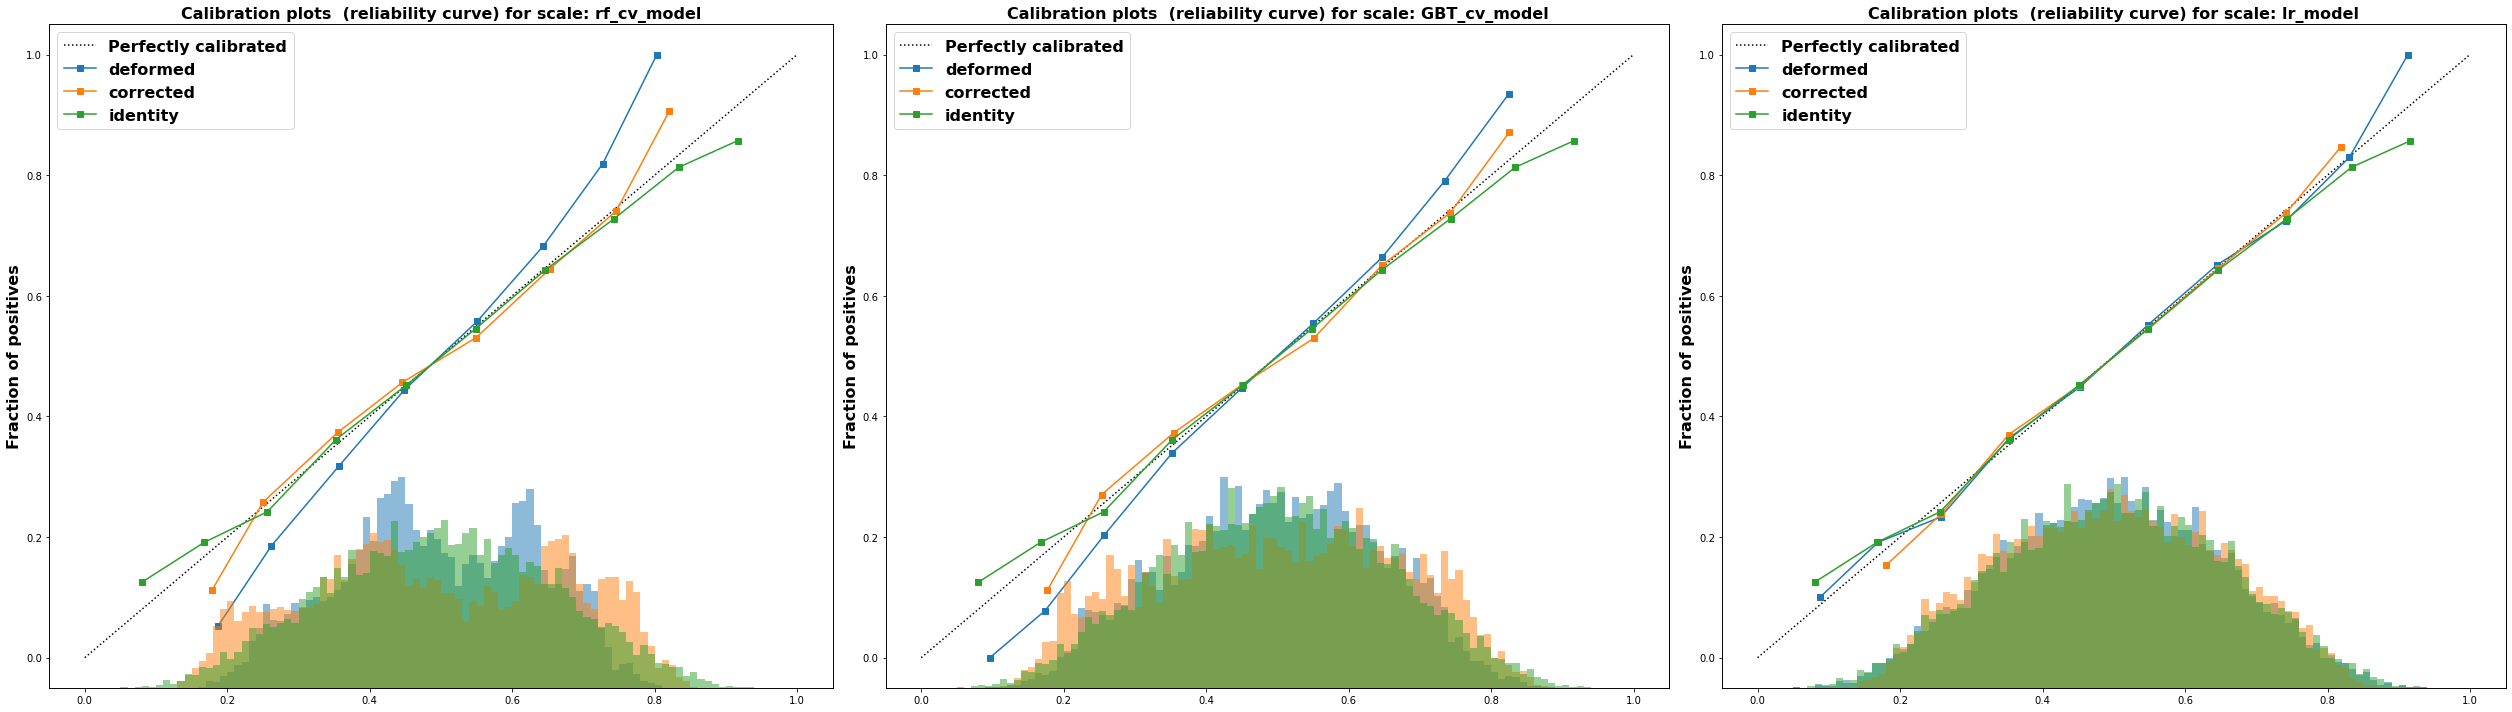

In [1005]:
# fig, axes = plt.subplots(nrows=3, ncols=4, sharex=True, sharey=True, figsize=(10,10))
# axes[0][1] = 
fig, axes = plt.subplots(1,3, figsize=(35, 10))
utils.plot_calibration_curve(res_dict, 'rf_cv_model', ax1=axes[0])
utils.plot_calibration_curve(res_dict, 'GBT_cv_model', ax1=axes[1])
utils.plot_calibration_curve(res_dict, 'lr_model', ax1=axes[2])

plt.tight_layout()

plt.savefig('simulation_models_calibration_curves.jpg', dpi=400)

In [1008]:
res_dict

{'t': array([0, 1, 0, ..., 1, 0, 0]),
 'prop': array([0.65140219, 0.77499229, 0.42434098, ..., 0.6211575 , 0.39202818,
        0.55609562]),
 'models': {0.125: {'deformed': array([0.51952783, 0.53857067, 0.49047059, ..., 0.51544709, 0.4862911 ,
          0.50704113]),
   'corrected': array([0.64535235, 0.76699472, 0.42414176, ..., 0.61577432, 0.39272102,
          0.55230742])},
  0.25: {'deformed': array([0.53899617, 0.576685  , 0.48094809, ..., 0.53086471, 0.47260279,
          0.51407947]),
   'corrected': array([0.64578908, 0.76672304, 0.42382657, ..., 0.61619609, 0.39231893,
          0.55254827])},
  0.3333333333333333: {'deformed': array([0.55191295, 0.60162474, 0.47460702, ..., 0.54111231, 0.46349882,
          0.51876877]),
   'corrected': array([0.64623203, 0.76643468, 0.4235044 , ..., 0.6166256 , 0.39190889,
          0.55279462])},
  0.5: {'deformed': array([0.57752079, 0.64984528, 0.46195143, ..., 0.5614951 , 0.44536961,
          0.52813663]),
   'corrected': array([0.647

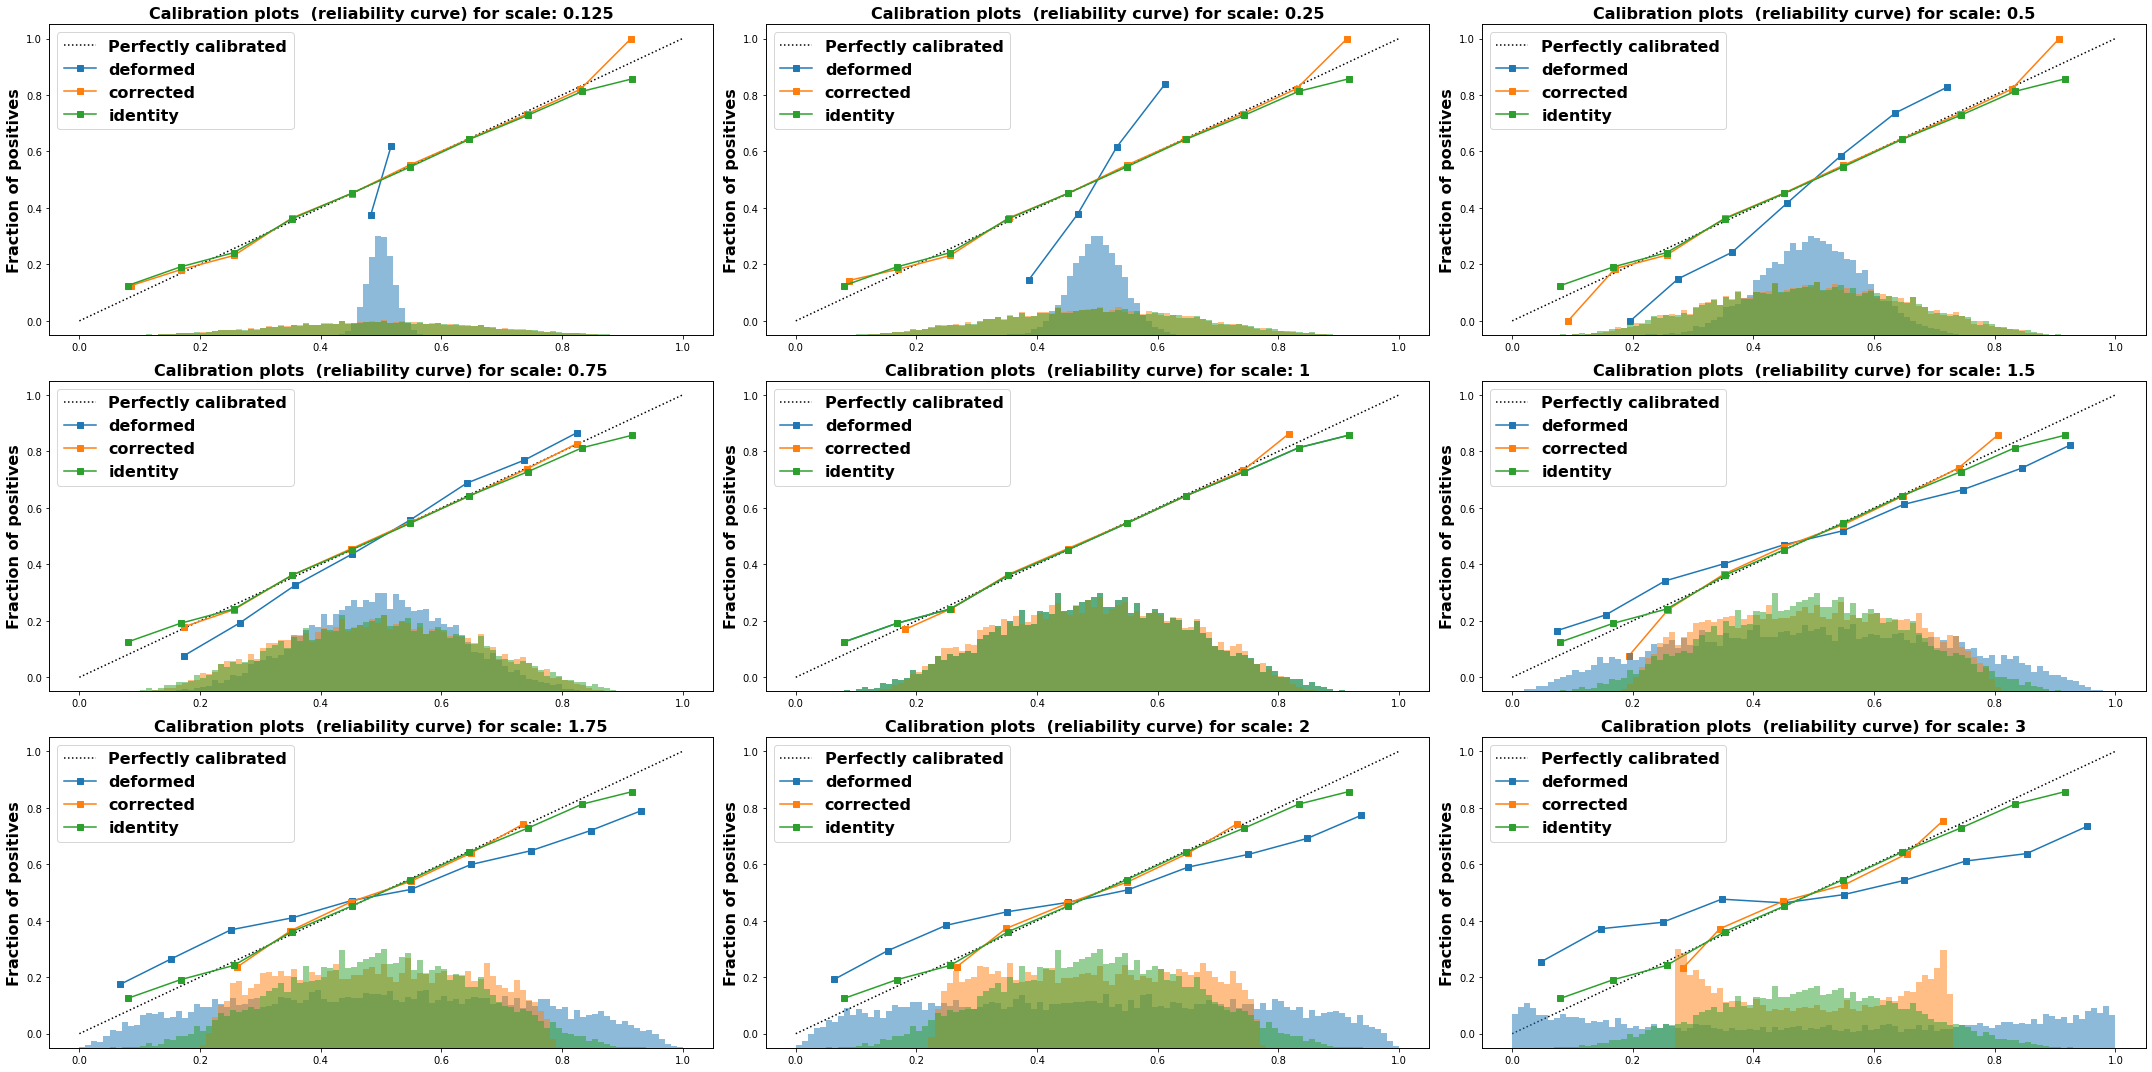

In [1014]:
scales = [0.125, 0.25, 0.5, 0.75, 1, 1.5, 1.75, 2, 3]
row_limit = 3
fig, axes = plt.subplots(row_limit, row_limit, figsize=(30, 15))
i, j = 0, 0
for idx, scale in enumerate(scales):
    utils.plot_calibration_curve(res_dict,scale, ax1=axes[i][j])
    j += 1
    if j >= row_limit:
        i += 1
        j = 0
# utils.plot_calibration_curve(res_dict, 'rf_cv_model', ax1=axes[0])
# utils.plot_calibration_curve(res_dict, 'GBT_cv_model', ax1=axes[1])
# utils.plot_calibration_curve(res_dict, 'lr_model', ax1=axes[2])

plt.tight_layout()

plt.savefig('simulation_deforming_calibration_curves.jpg', dpi=400)

In [1026]:
calib_df.to_csv('30_06_df.csv', index_label='simulation_run')

In [800]:
calib_df = pd.read_csv('models/30_06_df.csv')

,simulation_run,count,mean,std,min,10%,50%,90%,max,brier,type,scale,calibration_type,ATE,ATE_error
0,0,10000.0,0.123582,0.086162,1.938345e-05,0.021828,0.108951,0.243693,0.544065,0.243700,scaled_expit_0.125,0.125000,NaN,6.943086,1.943086
1,0,10000.0,0.016233,0.010315,1.674020e-06,0.004753,0.012716,0.031433,0.057248,0.226309,scaled_expit_0.125_calibrated,0.125000,sigmoid_calib,5.316181,0.316181
2,0,10000.0,0.106095,0.073173,3.697534e-05,0.019207,0.094022,0.208305,0.452002,0.238425,scaled_expit_0.25,0.250000,NaN,6.649197,1.649197
3,0,10000.0,0.016173,0.010432,4.121674e-06,0.004739,0.012536,0.031608,0.057709,0.226313,scaled_expit_0.25_calibrated,0.250000,sigmoid_calib,5.317492,0.317492
4,0,10000.0,0.094605,0.064718,1.828324e-05,0.017367,0.084136,0.184805,0.392215,0.235483,scaled_expit_0.3333333333333333,0.333333,NaN,6.468408,1.468408
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
215,9,10000.0,0.016235,0.016880,2.754845e-06,0.001066,0.008914,0.041377,0.080353,0.226466,scaled_expit_1.75_calibrated,1.750000,sigmoid_calib,4.920879,0.079121
216,9,10000.0,0.078631,0.038163,2.440766e-06,0.020637,0.084288,0.124595,0.159960,0.237890,scaled_expit_2,2.000000,NaN,2.175019,2.824981
217,9,10000.0,0.017043,0.016795,1.147093e-06,0.001549,0.010205,0.042177,0.074751,0.226690,scaled_expit_2_calibrated,2.000000,sigmoid_calib,4.941473,0.058527
218,9,10000.0,0.137239,0.060551,1.513836e-05,0.040676,0.150166,0.205198,0.228970,0.256833,scaled_expit_3,3.000000,NaN,-9.394135,14.394135


In [ ]:
def get_points(df, calib_metric, y_metric='ATE_error'):
    if df.shape[0] != 2: 
        print('warning!')
        display(df)
        raise ValueError('Bad df')
    x_y_orig = df.loc[df['calibration_type'].isna(), [calib_metric, y_metric]]
    x_y_calib = df.loc[~df['calibration_type'].isna(), [calib_metric, y_metric]]
    return (x_y_orig[calib_metric].iloc[0],
            x_y_orig[y_metric].iloc[0],
            (x_y_calib[calib_metric].iloc[0] - x_y_orig[calib_metric].iloc[0]),
            (x_y_calib[y_metric].iloc[0] - x_y_orig[y_metric].iloc[0]))

def get_arrows(df, calib_metric, y_metric='ATE_error'):

    gb = df.reset_index().groupby('index')

    arrows = []
    for g in gb.groups:
        arrows.append(gb.get_group(g).groupby('scale').apply(get_points, calib_metric, y_metric))

    arrows = pd.concat(arrows)
    return arrows


def plot_arrow(values):
    plt.arrow(*values, length_includes_head=True, lw=0.1, alpha=0.4, ls='--');

In [ ]:
plt.figure(figsize=(10,10))
temp_df = calib_df[model_rows].loc[lambda df: df['type'].str.contains('cv')]
sns.scatterplot(x='mean', y='ATE_error', data=temp_df, hue='type')
# plt.ylim(-0.01, 0.6)
# plt.xlim(-.01, 0.16)

plt.xlabel('E mean', fontdict={'weight': 'bold', 'size':17})
plt.ylabel('ATE Error', fontdict={'weight': 'bold', 'size':17})

arrows = get_arrows(temp_df, calib_metric='mean')

arrows.apply(plot_arrow);

/Users/romg/opt/anaconda3/lib/python3.8/site-packages/causallib/datasets/data_loader.py:135: FutureWarning: The 'lookup' method is deprecated and will beremoved in a future version.You can use DataFrame.melt and DataFrame.locas a substitute.
  y = y.lookup(y.index, a)  # Choose the outcome based on the treatment assignment


In [286]:
res_df = pd.read_csv('var.csv', index_col=[0])


,z,y,y.0,y.1,mu.0,mu.1,e
1,0,3.157727,3.157727,7.441336,3.890563,5.716108,0.451172
2,0,4.281244,4.281244,8.937312,5.870844,8.913574,0.403919
3,0,7.621447,7.621447,8.919930,7.006040,10.022676,0.517100
4,1,4.015639,-1.828240,4.015639,-1.046089,2.952779,0.388094
5,0,-0.240268,-0.240268,5.296278,-0.478072,6.246069,0.394039
...,...,...,...,...,...,...,...
4798,1,6.861145,2.868927,6.861145,3.468946,5.867435,0.323233
4799,1,9.796457,4.512699,9.796457,4.827529,9.988942,0.398313
4800,1,10.910222,3.807379,10.910222,4.183918,9.469441,0.250085
4801,1,12.444005,5.168389,12.444005,4.684806,11.919826,0.270711


# synthetic data

In [15]:
from causallib.datasets import load_acic16


x_acic = load_acic16(instance=1, raw=False)['X']

/Users/romg/opt/anaconda3/lib/python3.8/site-packages/causallib/datasets/data_loader.py:135: FutureWarning: The 'lookup' method is deprecated and will beremoved in a future version.You can use DataFrame.melt and DataFrame.locas a substitute.
  y = y.lookup(y.index, a)  # Choose the outcome based on the treatment assignment


In [250]:
from glob import glob
import re

reg = r'(?<=var)\d{1,2}_\d{1,2}'

def get_expr_id(s, r_pattern):
    return re.findall(r_pattern, s)[0]

cur_dir = os.path.abspath(os.getcwd())
data_dir = os.path.join(cur_dir, "data")
pattern = 'var*_*.csv'

target_files_list = glob(os.path.join(data_dir, pattern))



In [441]:
rel_target_list = sorted([f for f in target_files_list if get_expr_id(f, reg).split('_')[0] == '42'])

In [512]:
rel_target_list

['/Users/romg/PycharmProjects/Propensity/data/var42_1.csv',
 '/Users/romg/PycharmProjects/Propensity/data/var42_2.csv',
 '/Users/romg/PycharmProjects/Propensity/data/var42_3.csv',
 '/Users/romg/PycharmProjects/Propensity/data/var42_4.csv',
 '/Users/romg/PycharmProjects/Propensity/data/var42_5.csv']

### todo:

- parameters
- pipeline


In [1048]:


rf_tuned_parameters = [{'max_depth': [5, 10, 20, 30],
                     'n_estimators': [50, 100, 200, 400, 1000]}]

gb_tuned_parameters = [{'max_depth': [1, 2, 3, 6],
                        'learning_rate': [0.01, 0.05, 0.1],
                     'n_estimators': [30, 50, 100, 250, 500, 1000]}]

scores = 'neg_brier_score'

cv_inner = KFold(n_splits=10, shuffle=True, random_state=42)


model_experiments = {
    'lr': LogisticRegression(random_state=42, n_jobs=-1, penalty='none'),
    'lr_l1': LogisticRegressionCV(random_state=42, n_jobs=-1, cv=10, solver='saga', penalty='l1', max_iter=1e4),
    'lr_l2': LogisticRegressionCV(random_state=42, n_jobs=-1, cv=10, solver='saga', penalty='l2', max_iter=1e4),
    'GBT_cv': GridSearchCV(GradientBoostingClassifier(random_state=42), gb_tuned_parameters, scoring=scores, n_jobs=-1, cv=cv_inner),
    'rf_cv': GridSearchCV(RandomForestClassifier(random_state=42, oob_score=True), rf_tuned_parameters, scoring=scores, n_jobs=-1, cv=cv_inner),
    'identity': None
}

In [565]:
df_42_nested_sig_test.to_csv('test_df_42_nested_sig.csv')

In [1049]:
from copy import deepcopy
from tqdm import tqdm

def run_multiple_experiments(experiment_files, model_experiments):
    df_list = []
    for instance in tqdm(experiment_files): 
        models = deepcopy(model_experiments)
        id_ = get_expr_id(instance, reg)
        instance_df = pd.read_csv(instance, index_col=[0]).reset_index(drop=True)
        po = instance_df[['y.0', 'y.1']].copy()
        po.columns = [0, 1]
        e = instance_df['e'].copy()
        c_df_1 = utils.run_synthetic_experiments(var = x_acic,
                                t=instance_df['z'],
                                e=e,
                                potential_outcomes=po,
                                experiments=models,
                                post_colab_func=utils.sigmoid_calib,
                                save=True, save_name=f'models_test/acic{id_}_new_sig.pkl',id_=id_,
                                nested_cv=True
                               )
        ate = (po[1] - po[0]).mean()
        c_df_1['ATE_error'] = (c_df_1['ATE'] - ate).pipe(lambda x: np.sqrt(x ** 2))
        df_list.append(c_df_1)
    return pd.concat(df_list)


df_42_nested_sig_new = run_multiple_experiments(rel_target_list, model_experiments)

  0%|          | 0/5 [00:00<?, ?it/s]/Users/romg/PycharmProjects/Propensity/utils.py:246: UserWarning: for experiment identity, predicting identity
  warnings.warn(f'for experiment {expr}, predicting identity')
 20%|██        | 1/5 [1:03:27<4:13:51, 3807.94s/it]/Users/romg/PycharmProjects/Propensity/utils.py:246: UserWarning: for experiment identity, predicting identity
  warnings.warn(f'for experiment {expr}, predicting identity')
 40%|████      | 2/5 [2:07:54<3:12:07, 3842.41s/it]/Users/romg/PycharmProjects/Propensity/utils.py:246: UserWarning: for experiment identity, predicting identity
  warnings.warn(f'for experiment {expr}, predicting identity')
 60%|██████    | 3/5 [3:50:46<2:43:32, 4906.13s/it]/Users/romg/PycharmProjects/Propensity/utils.py:246: UserWarning: for experiment identity, predicting identity
  warnings.warn(f'for experiment {expr}, predicting identity')
 80%|████████  | 4/5 [6:01:33<1:41:07, 6067.01s/it]/Users/romg/PycharmProjects/Propensity/utils.py:246: UserWarnin

In [1042]:
df_42_nested_sig_lr.to_csv('nested_sig_with_lr.csv')

In [479]:
df_42_nested_experiments_sig.to_csv('nested_acis_42_sig.csv')

In [471]:
instance = rel_target_list[1]
id_ = get_expr_id(instance, reg)
instance_df = pd.read_csv(instance, index_col=[0])
po = instance_df[['y.0', 'y.1']].copy()
po.columns = [0, 1]
e = instance_df['e'].copy()


In [472]:
get_expr_id(instance, reg)

'42_2'

In [473]:
c_df_1 = utils.run_synthetic_experiments(var = x_acic,
                                t=instance_df['z'],
                                e=e,
                                potential_outcomes=po,
                                experiments=deepcopy(model_experiments),
                                post_colab_func=utils.sigmoid_calib,
                                save=False, save_name=f'acic{id_}_sig.pkl',id_=id_, nested_cv=False
                               )

/Users/romg/PycharmProjects/Propensity/utils.py:236: UserWarning: for experiment identity, predicting identity
  if save:


In [474]:
ate = (po[1] - po[0]).mean()

c_df_1['ATE_error'] = (c_df_1['ATE'] - ate).pipe(lambda x: np.sqrt(x ** 2))

In [1078]:
df_42_nested_sig_lr.query('scale == "rf_cv_model"')

,count,mean,std,min,10%,50%,90%,max,brier,type,scale,calibration_type,ATE,Balancing,ATE_error
42_1,4802.0,0.124322,0.086252,5.928428e-05,0.027367,0.113334,0.240145,0.556343,0.218033,rf_cv,rf_cv_model,None,2.903261,0.085169,0.342150
42_1,4802.0,0.056271,0.038655,1.623310e-05,0.018546,0.047518,0.111769,0.223816,0.205875,rf_cv_calibrated,rf_cv_model,sigmoid_calib,2.819054,0.077568,0.257943
42_2,4802.0,0.082787,0.069482,1.356538e-05,0.012854,0.066915,0.166953,0.544714,0.226713,rf_cv,rf_cv_model,None,3.787589,0.121411,0.221794
42_2,4802.0,0.033872,0.033198,1.596307e-06,0.004588,0.020479,0.077551,0.222837,0.220307,rf_cv_calibrated,rf_cv_model,sigmoid_calib,3.607027,0.073899,0.041232
42_3,4802.0,0.090312,0.069983,5.979360e-05,0.014738,0.070455,0.190166,0.346784,0.224832,rf_cv,rf_cv_model,None,3.443967,0.124210,0.432946
42_3,4802.0,0.032690,0.022352,4.313785e-06,0.006748,0.028967,0.069933,0.083384,0.216036,rf_cv_calibrated,rf_cv_model,sigmoid_calib,2.728922,0.131584,0.282099
42_4,4802.0,0.099309,0.079087,2.378585e-05,0.016877,0.084620,0.194009,0.767021,0.238037,rf_cv,rf_cv_model,None,4.804357,0.075927,0.592439
42_4,4802.0,0.025871,0.016847,2.479713e-07,0.005318,0.025134,0.045005,0.121314,0.225721,rf_cv_calibrated,rf_cv_model,sigmoid_calib,3.898828,0.065436,0.313091
42_5,4802.0,0.112139,0.079739,8.246493e-05,0.027866,0.101798,0.192096,0.675591,0.219797,rf_cv,rf_cv_model,None,7.127379,0.075485,0.086538
42_5,4802.0,0.061988,0.018104,8.233141e-05,0.036721,0.067038,0.078531,0.079262,0.210219,rf_cv_calibrated,rf_cv_model,sigmoid_calib,7.271476,0.084229,0.057560


In [1079]:
df_42_nested_sig_new.query('scale == "rf_cv_model"')

,count,mean,std,min,10%,50%,90%,max,brier,type,scale,calibration_type,ATE,Balancing,ATE_error
42_1,4802.0,0.084156,0.025787,0.000097,0.054607,0.085733,0.109574,0.293549,0.221079,rf_cv,rf_cv_model,None,2.864739,0.086556,0.303628
42_1,4802.0,0.073678,0.012944,0.000275,0.072065,0.076236,0.080279,0.116991,0.220058,rf_cv_calibrated,rf_cv_model,sigmoid_calib,2.795138,0.073834,0.234027
42_2,4802.0,0.060555,0.029213,0.000025,0.035658,0.056562,0.078725,0.348605,0.229890,rf_cv,rf_cv_model,None,3.793813,0.125253,0.228018
42_2,4802.0,0.045849,0.011769,0.000243,0.041427,0.045419,0.057788,0.159368,0.228809,rf_cv_calibrated,rf_cv_model,sigmoid_calib,3.724494,0.111623,0.158699
42_3,4802.0,0.051132,0.023335,0.000036,0.020240,0.050630,0.076189,0.176008,0.228212,rf_cv,rf_cv_model,None,3.447320,0.123992,0.436299
42_3,4802.0,0.033149,0.015444,0.000025,0.004626,0.035345,0.050066,0.076198,0.227195,rf_cv_calibrated,rf_cv_model,sigmoid_calib,3.220495,0.116991,0.209474
42_4,4802.0,0.022673,0.012014,0.002956,0.012301,0.022075,0.031338,0.315778,0.239563,rf_cv,rf_cv_model,None,4.817595,0.076233,0.605677
42_4,4802.0,0.022558,0.010795,0.000199,0.014060,0.020620,0.034995,0.254934,0.239532,rf_cv_calibrated,rf_cv_model,sigmoid_calib,4.785160,0.075934,0.573241
42_5,4802.0,0.071878,0.021800,0.000043,0.051128,0.072138,0.095162,0.343222,0.222717,rf_cv,rf_cv_model,None,7.181407,0.075381,0.032510
42_5,4802.0,0.068751,0.016295,0.000225,0.047419,0.070843,0.086081,0.203767,0.222452,rf_cv_calibrated,rf_cv_model,sigmoid_calib,7.230818,0.077404,0.016902


In [342]:
c_df_1_ir = c_df_1.copy()

In [369]:
df_42_nested_experiments_sig = df_4_nested_experiments_sig.copy()

In [571]:
df_42_nested_sig.query('scale == "rf_cv_model"')

,count,mean,std,min,10%,50%,90%,max,brier,type,scale,calibration_type,ATE,Balancing,ATE_error
42_1,4802.0,0.124322,0.086252,5.928428e-05,0.027367,0.113334,0.240145,0.556343,0.218033,rf_cv,rf_cv_model,None,2.903261,0.085169,0.342150
42_1,4802.0,0.056271,0.038655,1.623310e-05,0.018546,0.047518,0.111769,0.223816,0.205875,rf_cv_calibrated,rf_cv_model,sigmoid_calib,2.819054,0.077568,0.257943
42_2,4802.0,0.082787,0.069482,1.356538e-05,0.012854,0.066915,0.166953,0.544714,0.226713,rf_cv,rf_cv_model,None,3.787589,0.121411,0.221794
42_2,4802.0,0.033872,0.033198,1.596307e-06,0.004588,0.020479,0.077551,0.222837,0.220307,rf_cv_calibrated,rf_cv_model,sigmoid_calib,3.607027,0.073899,0.041232
42_3,4802.0,0.090312,0.069983,5.979360e-05,0.014738,0.070455,0.190166,0.346784,0.224832,rf_cv,rf_cv_model,None,3.443967,0.124210,0.432946
42_3,4802.0,0.032690,0.022352,4.313785e-06,0.006748,0.028967,0.069933,0.083384,0.216036,rf_cv_calibrated,rf_cv_model,sigmoid_calib,2.728922,0.131584,0.282099
42_4,4802.0,0.099309,0.079087,2.378585e-05,0.016877,0.084620,0.194009,0.767021,0.238037,rf_cv,rf_cv_model,None,4.804357,0.075927,0.592439
42_4,4802.0,0.025871,0.016847,2.479713e-07,0.005318,0.025134,0.045005,0.121314,0.225721,rf_cv_calibrated,rf_cv_model,sigmoid_calib,3.898828,0.065436,0.313091
42_5,4802.0,0.112139,0.079739,8.246493e-05,0.027866,0.101798,0.192096,0.675591,0.219797,rf_cv,rf_cv_model,None,7.127379,0.075485,0.086538
42_5,4802.0,0.061988,0.018104,8.233141e-05,0.036721,0.067038,0.078531,0.079262,0.210219,rf_cv_calibrated,rf_cv_model,sigmoid_calib,7.271476,0.084229,0.057560


In [1027]:
# lr_colors = a.get_children()[0].get_children()[1].get_children()[0].get_children()[0].get_children()[0].get_children()[0]._facecolors

lr_colors = [0.12156863, 0.46666667, 0.70588235, 1.]
gbt_color = [1., 0.49803922, 0.05490196, 1.]
rf_color = [0.17254902, 0.62745098, 0.17254902, 1.]


def plot_comp_plot(big_df, metric='mean', y_metric='ATE_error', x_label='Calibration error', y_label='Effect estimation error'):
    fig = plt.figure(figsize=(10,10))
    for type_, marker in zip(['model', 'calibrated'], ['s', 'o']):
        mask = big_df['calibration_type'].isna() if type_ == 'model' else ~big_df['calibration_type'].isna()
        temp_df = big_df.loc[mask]
#         print(temp_df.shape[0])
        ax = sns.scatterplot(x=metric, y=y_metric, data=temp_df, hue='scale', marker=marker, legend=True)
    temp_df = big_df

    plt.xlabel(x_label, fontdict={'weight': 'bold', 'size':17})
    plt.ylabel(y_label, fontdict={'weight': 'bold', 'size':17})

    arrows = utils.get_arrows(temp_df, calib_metric=metric, y_metric=y_metric)

    arrows.apply(utils.plot_arrow, ax=ax);
    return ax
#     legend_elements = [Patch(facecolor=lr_colors, edgecolor='w',
#                          label='LR'),
#                    Patch(facecolor=gbt_color, edgecolor='w',
#                          label='GBT'),
#                    Patch(facecolor=rf_color, edgecolor='w',
#                          label='RF'),
#                    Line2D([0], [0], marker='s', color='w', markeredgecolor='black', lw=4, alpha=1, label='Uncalibrated', 
#                          markerfacecolor='w', markersize=9),
#                    Line2D([0], [0], marker='o', color='w', markeredgecolor='black', lw=4, alpha=1, label='Calibrated',
#                           markerfacecolor='w', markersize=9),
#                   ]
#     plt.legend(handles=legend_elements, prop={'weight':'bold', 'size':10} )

In [988]:
def get_row_slope(row):
    _, _, mx, my = row
    return -my/mx

def get_slopes(df, x_metric='mean', y_metric='ATE_error'):
    arrows = utils.get_arrows(df, calib_metric=x_metric, y_metric=y_metric)
    slopes = arrows.apply(get_row_slope)
    return slopes.to_frame().reset_index().groupby('scale').describe()
    

In [1051]:
display(get_slopes(df_42_nested_sig_new.query("scale != 'identity_model'")))
display(get_slopes(df_42_nested_sig_new.query("scale != 'identity_model'"),x_metric='mean', y_metric='Balancing'))
display(get_slopes(df_42_nested_sig_new.query("scale != 'identity_model'"),x_metric='Balancing'))


0                                                      \
             count         mean          std          min          25%   
scale                                                                    
GBT_cv_model   5.0  -109.815367   252.726709  -558.994968   -24.636005   
lr_l1_model    5.0    13.598185    65.773875   -49.088091    -5.843284   
lr_l2_model    5.0    -4.529104   107.729202  -154.033874   -66.479147   
lr_model       5.0 -1512.022383  2133.911922 -5101.605351 -1799.404602   
rf_cv_model    5.0   -62.006972   122.504156  -281.074827   -12.613005   

                                                 
                     50%        75%         max  
scale                                            
GBT_cv_model  -12.299311  -3.490088   50.343536  
lr_l1_model    -4.021976   1.375530  125.568748  
lr_l2_model    29.679172  43.140124  125.048203  
lr_model     -614.266325 -59.944347   15.108710  
rf_cv_model    -6.642354  -4.991193   -4.713479

0                                                          \
             count       mean         std         min        25%       50%   
scale                                                                        
GBT_cv_model   5.0  -0.877490    1.362005   -3.066112  -0.888859 -0.565759   
lr_l1_model    5.0  -0.398889    1.174992   -2.481751  -0.056370 -0.006672   
lr_l2_model    5.0  -0.307142    3.253656   -4.106132  -1.288408 -1.161292   
lr_model       5.0 -25.914408  112.464491 -207.005785 -20.834579 -4.947180   
rf_cv_model    5.0  -0.894375    1.183648   -2.588572  -1.214090 -0.926789   

                                    
                   75%         max  
scale                               
GBT_cv_model -0.545772    0.679052  
lr_l1_model   0.229171    0.321178  
lr_l2_model   0.235517    4.784603  
lr_model      0.060879  103.154624  
rf_cv_model  -0.389285    0.646859

0                                                             \
             count        mean         std         min         25%        50%   
scale                                                                           
GBT_cv_model   5.0  -16.702385  101.981872 -182.313943  -22.535629  -3.926481   
lr_l1_model    5.0 -303.826154  390.891836 -875.794191 -547.924806 -71.349390   
lr_l2_model    5.0  -63.898933   85.188244 -183.172290 -119.553654 -26.135545   
lr_model       5.0  -73.070048  103.856298 -248.177175  -86.366255 -24.644748   
rf_cv_model    5.0  -28.764842   46.952909 -108.582972  -32.400407  -5.471054   

                                    
                    75%        max  
scale                               
GBT_cv_model  36.280017  88.984113  
lr_l1_model  -19.779617  -4.282768  
lr_l2_model  -16.190213  25.557036  
lr_model     -12.116873   5.954811  
rf_cv_model   -5.085819   7.716041

<Figure size 432x288 with 0 Axes>

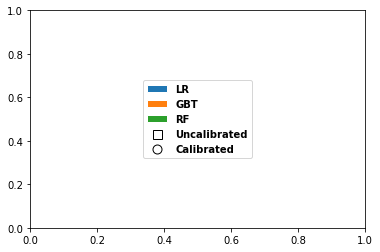

In [640]:

plt.figure();
legend_elements = [Patch(facecolor=lr_colors, edgecolor='w',
                         label='LR'),
                   Patch(facecolor=gbt_color, edgecolor='w',
                         label='GBT'),
                   Patch(facecolor=rf_color, edgecolor='w',
                         label='RF'),
                   Line2D([0], [0], marker='s', color='w', markeredgecolor='black', lw=4, alpha=1, label='Uncalibrated', 
                         markerfacecolor='w', markersize=9),
                   Line2D([0], [0], marker='o', color='w', markeredgecolor='black', lw=4, alpha=1, label='Calibrated',
                          markerfacecolor='w', markersize=9),
                  ]

# Create the figure
fig, ax = plt.subplots()
ax.legend(handles=legend_elements, prop={'weight':'bold', 'size':10} )

15
15


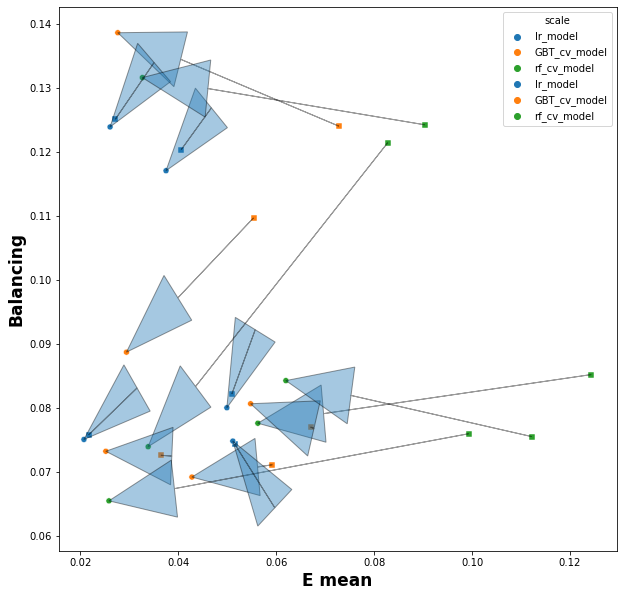

In [582]:
plot_comp_plot(df_42_nested_sig.query("scale != 'identity_model'"), metric='mean', y_metric='Balancing', y_label='Balancing')
plt.savefig('42_nested_sig_calib_balancing.jpg', dpi=300)

15
15


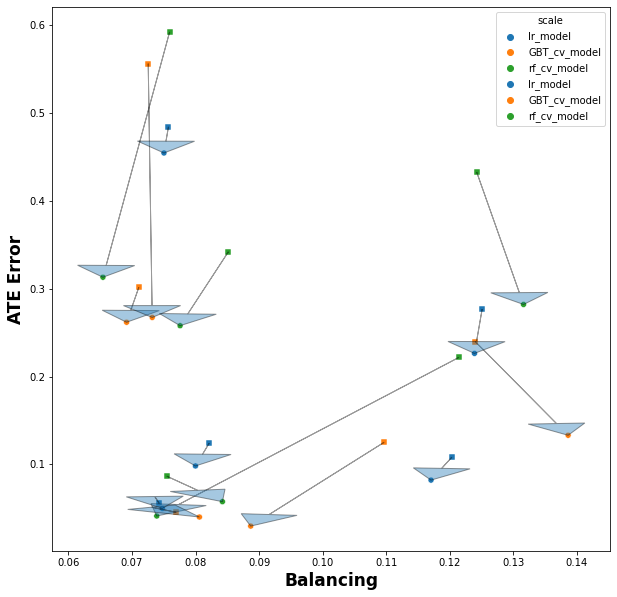

In [581]:
plot_comp_plot(df_42_nested_sig.query("scale != 'identity_model'"), metric='Balancing', x_label='Balancing')
plt.savefig('42_nested_sig_balancing.jpg', dpi=300)

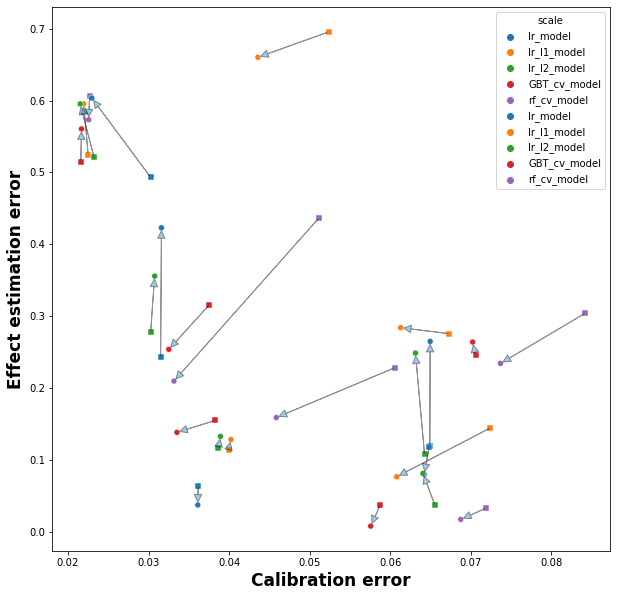

In [1052]:
a = plot_comp_plot(df_42_nested_sig_new.query("scale != 'identity_model'"), metric='mean')
# plt.savefig('42_nested_sig.jpg', dpi=300)

In [1040]:
a.get_children()[4]._facecolors

#.get_children()[1].get_children()[0].get_children()[0].get_children()[0].get_children()[0]._facecolors

array([[0.83921569, 0.15294118, 0.15686275, 1.        ]])

15
15
15
15


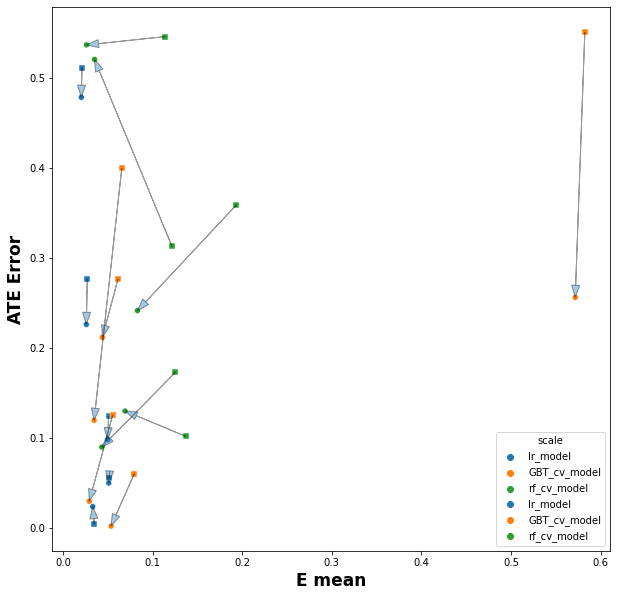

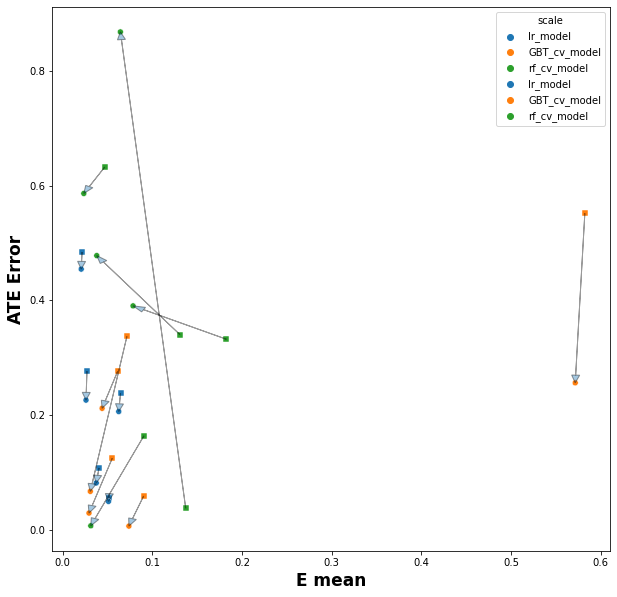

In [444]:
plot_comp_plot(df_42_nested_experiments_sig.loc[~df_42_nested_experiments_sig['type'].str.contains('identity')])
plot_comp_plot(df_4_experiments_sig.loc[~df_4_experiments_sig['type'].str.contains('identity')])


15
15


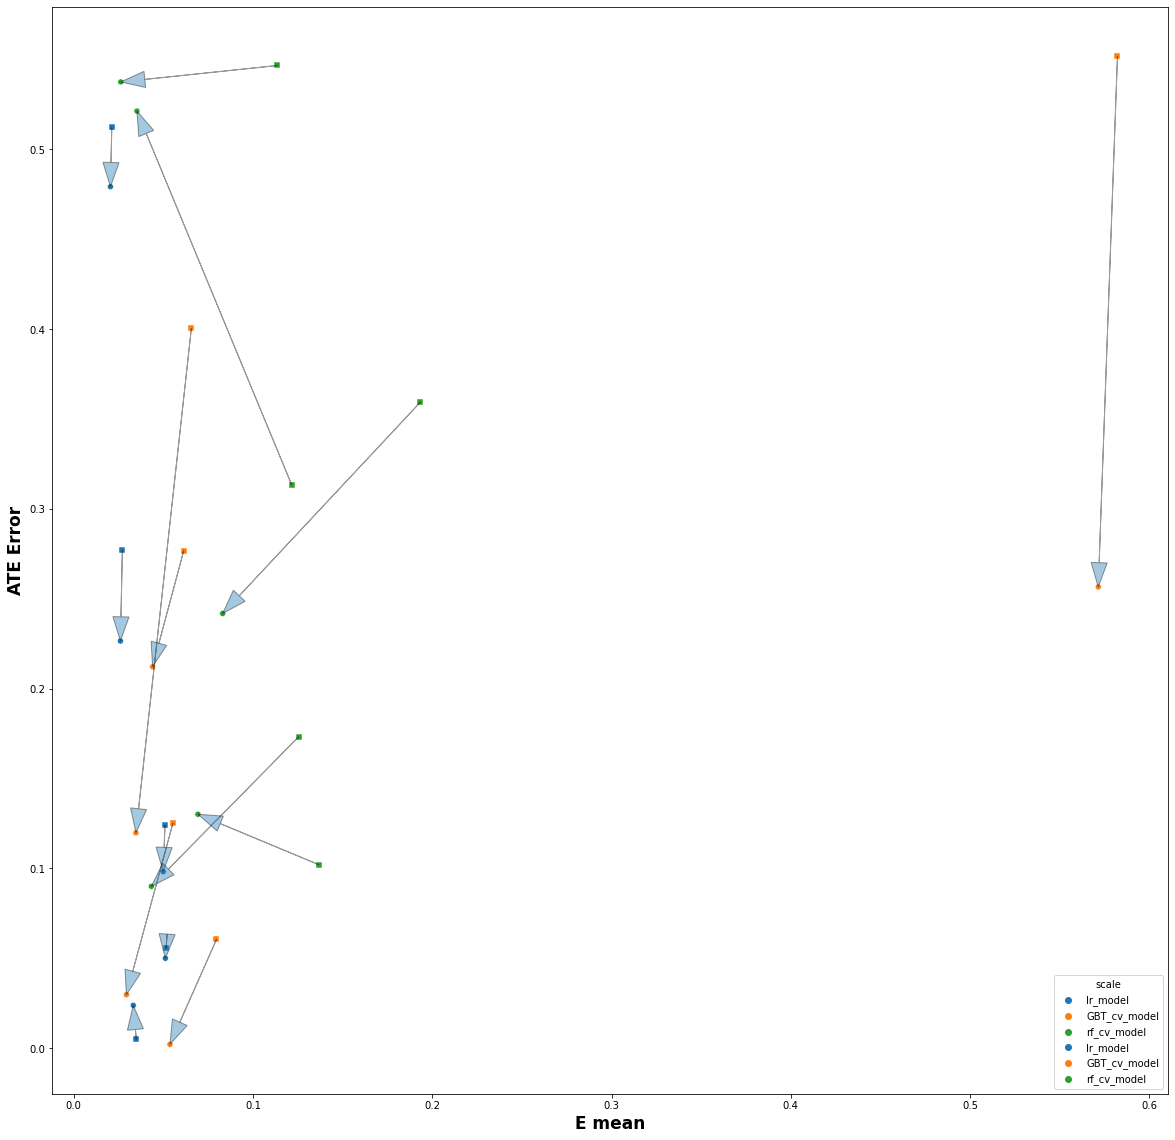

In [348]:
big_df = df_4_experiments_sig.loc[~df_4_experiments_sig['type'].str.contains('identity')]
plt.figure(figsize=(20,20))
for type_, marker in zip(['model', 'calibrated'], ['s', 'o']):
    mask = big_df['calibration_type'].isna() if type_ == 'model' else ~big_df['calibration_type'].isna()
    temp_df = big_df.loc[mask]
    print(temp_df.shape[0])
    sns.scatterplot(x='mean', y='ATE_error', data=temp_df, hue='scale', marker=marker)
temp_df = big_df
# plt.ylim(-0.01, 0.6)
# plt.xlim(-.01, 0.16)

plt.xlabel('E mean', fontdict={'weight': 'bold', 'size':17})
plt.ylabel('ATE Error', fontdict={'weight': 'bold', 'size':17})

arrows = utils.get_arrows(temp_df, calib_metric='mean')

arrows.apply(utils.plot_arrow);

# plt.save_fig('')

(0.05923578840709255, 0.3016059687789494) (0.0428035900579695, 0.26184157390497464)
(0.05096981636202825, 0.12416574882707376) (0.049943597063264074, 0.09820236948882322)
(0.12432158668173583, 0.3421502572448616) (0.05627071863848791, 0.257942778409332)
(0.05538246861342054, 0.12513825618947738) (0.029447674937661174, 0.029752220398176377)
(0.04061904001975273, 0.10825800328175239) (0.03752244618801777, 0.0821063425872639)
(0.08278705184815868, 0.22179417959296677) (0.03387181409469604, 0.04123193683729909)
(0.07280568736088695, 0.23987040778581692) (0.027675247019407316, 0.13313995444817284)
(0.027177364894346336, 0.27685273802051835) (0.026099396919411495, 0.22638210252602553)
(0.09031202455647147, 0.4329456640630083) (0.03269048187918971, 0.28209898401659084)
(0.03647737973916238, 0.5563858251134288) (0.025227079147418913, 0.26732697637893565)
(0.02172280127008047, 0.4843685392675514) (0.020766974903283174, 0.45455899469213357)
(0.09930923406183366, 0.5924385046113567) (0.0258714856

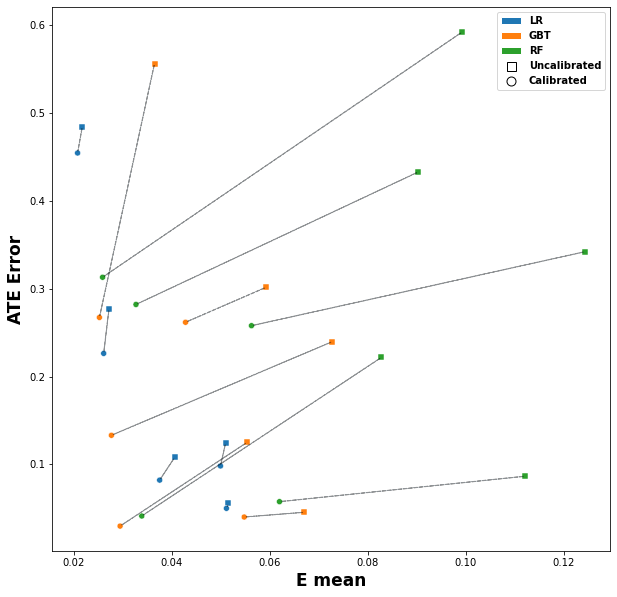

In [676]:
# fig = plt.figure(figsize=(4,4))
plot_comp_plot(df_42_nested_sig.query("scale != 'identity_model'"), metric='mean')

# arrows.apply(utils.plot_arrow, fig=fig);


In [767]:
import pickle
with open("models_test/acic42_2_sig.pkl", 'rb') as f:
    res_dict = pickle.load(f)

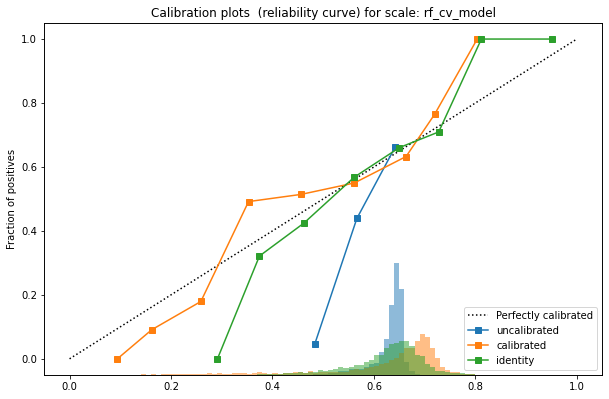

In [749]:
a = utils.plot_calibration_curve(res_dict, 'rf_cv_model')

In [769]:
res_dict['models'].keys()

dict_keys(['lr_model', 'GBT_cv_model', 'rf_cv_model', 'identity_model'])

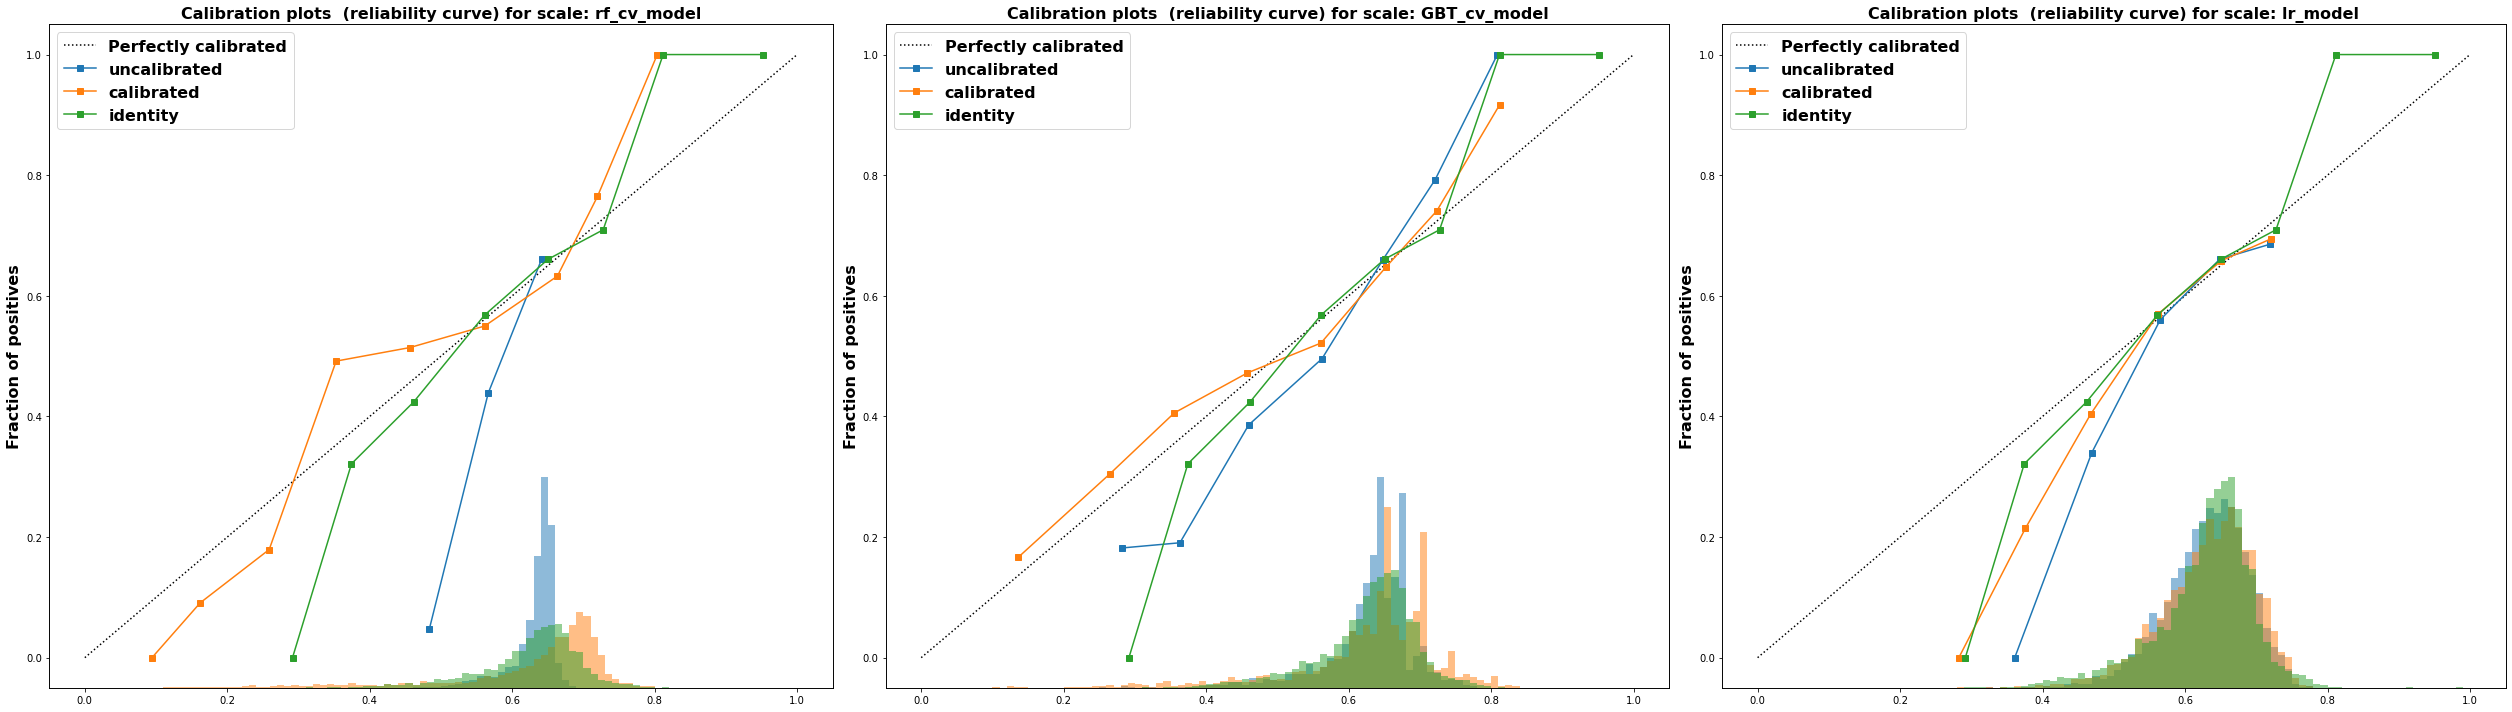

In [778]:
fig, axes = plt.subplots(1,3, figsize=(35, 10))
utils.plot_calibration_curve(res_dict, 'rf_cv_model', ax1=axes[0])
utils.plot_calibration_curve(res_dict, 'GBT_cv_model', ax1=axes[1])
utils.plot_calibration_curve(res_dict, 'lr_model', ax1=axes[2])

plt.tight_layout()
plt.savefig('calibration_acis.jpg', dpi=400)

In [757]:
a.get_ybound()

(0.0, 1381.8)

In [450]:
df_42_nested_experiments_sig.loc['42_2']

,count,mean,std,min,10%,50%,90%,max,brier,type,scale,calibration_type,ATE,ATE_error
42_2,4802.0,0.034964,0.016046,0.000004,0.017021,0.036085,0.047560,0.244957,0.227602,lr,lr_model,None,3.560872,0.004923
42_2,4802.0,0.033266,0.013479,0.000166,0.017695,0.034701,0.045062,0.198845,0.227503,lr_calibrated,lr_model,sigmoid_calib,3.541959,0.023836
42_2,4802.0,0.055382,0.034616,0.000011,0.014928,0.045168,0.100552,0.236329,0.224040,GBT_cv,GBT_cv_model,None,3.690933,0.125138
42_2,4802.0,0.029448,0.020604,0.000002,0.001604,0.030272,0.051760,0.118060,0.222555,GBT_cv_calibrated,GBT_cv_model,sigmoid_calib,3.595547,0.029752
42_2,4802.0,0.125509,0.088337,0.000068,0.022692,0.115220,0.235694,0.676733,0.220049,rf_cv,rf_cv_model,None,3.738965,0.173170
42_2,4802.0,0.043356,0.035913,0.000001,0.009244,0.031859,0.095965,0.215514,0.205655,rf_cv_calibrated,rf_cv_model,sigmoid_calib,3.475794,0.090001
42_2,4802.0,0.040790,0.013869,0.000119,0.023753,0.043957,0.049675,0.181421,0.227222,identity,identity_model,None,3.620787,0.054992
42_2,4802.0,0.034522,0.010692,0.000077,0.020792,0.037375,0.041746,0.136400,0.227115,identity_calibrated,identity_model,sigmoid_calib,3.563773,0.002023


In [461]:
df_4_experiments_sig.loc['42_2']

,count,mean,std,min,10%,50%,90%,max,brier,type,scale,calibration_type,ATE,ATE_error
42_2,4802.0,0.040615,0.023145,0.000055,0.013899,0.043453,0.056429,0.370160,0.228583,lr,lr_model,None,3.674049,0.108254
42_2,4802.0,0.037531,0.020873,0.000007,0.010617,0.040635,0.054664,0.303292,0.228405,lr_calibrated,lr_model,sigmoid_calib,3.647884,0.082089
42_2,4802.0,0.055382,0.034616,0.000011,0.014928,0.045168,0.100552,0.236329,0.224040,GBT_cv,GBT_cv_model,None,3.690933,0.125138
42_2,4802.0,0.029448,0.020604,0.000002,0.001604,0.030272,0.051760,0.118060,0.222555,GBT_cv_calibrated,GBT_cv_model,sigmoid_calib,3.595547,0.029752
42_2,4802.0,0.090673,0.062694,0.000012,0.018560,0.081854,0.162936,0.526184,0.220419,rf_cv,rf_cv_model,None,3.730050,0.164255
42_2,4802.0,0.031449,0.026502,0.000007,0.003186,0.027494,0.069289,0.122739,0.213799,rf_cv_calibrated,rf_cv_model,sigmoid_calib,3.573394,0.007599
42_2,4802.0,0.040790,0.013869,0.000119,0.023753,0.043957,0.049675,0.181421,0.227222,identity,identity_model,None,3.620787,0.054992
42_2,4802.0,0.034522,0.010692,0.000077,0.020792,0.037375,0.041746,0.136400,0.227115,identity_calibrated,identity_model,sigmoid_calib,3.563773,0.002023


In [148]:
# np.where(t_temp == 1, )



array([0.51437104, 0.25924421, 0.2887585 , ..., 0.1826718 , 0.32126219,
       0.1660818 ])

In [151]:
def plot_overlap(t, prop):
    fig = plt.figure(figsize=(10, 10))
    plt.hist(prop[t == 1], bins=20, color='cornflowerblue', alpha=0.7, label= 'Treated');
    plt.hist(prop[t == 0], bins=20, color='red', alpha=0.7, label= 'Control');

    plt.legend();
    

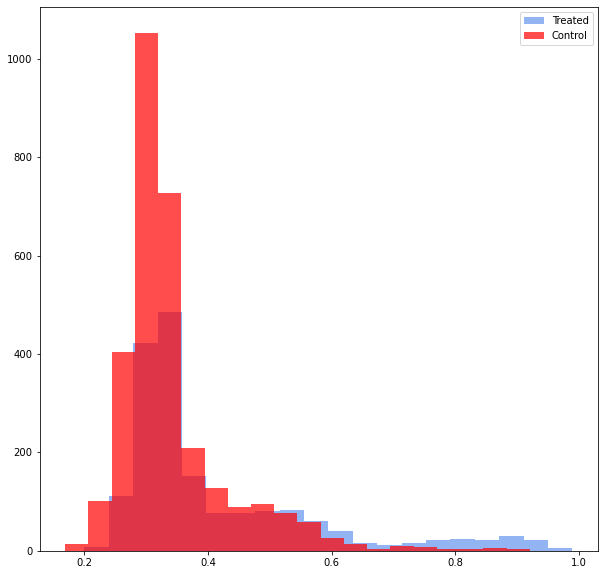

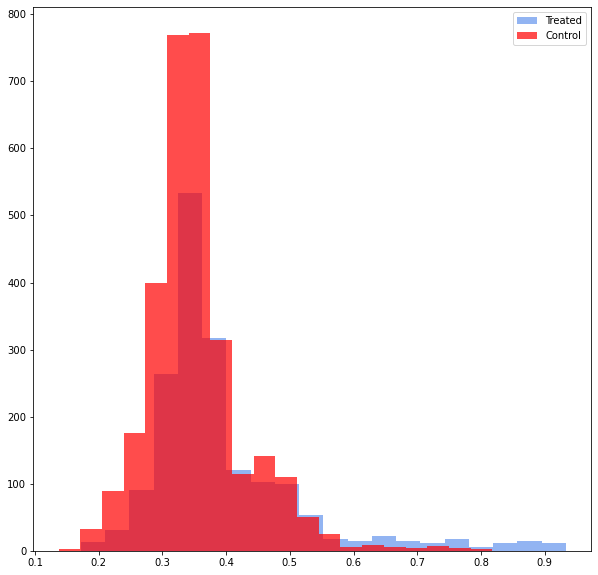

In [389]:
plot_overlap(res_dict['t'].values, res_dict['models']['rf_cv_model']['calibrated'])
plot_overlap(res_dict['t'].values, res_dict['models']['identity_model']['calibrated'])

In [494]:
from sklearn.model_selection import cross_val_score, KFold, cross_val_predict

cv_inner = KFold(n_splits=5, shuffle=True, random_state=2408)
model = RandomForestClassifier(random_state=42, oob_score=True)


search = GridSearchCV(model, tuned_parameters, scoring=scores, n_jobs=-1, cv=cv_inner, refit=True)

cv_outer = KFold(n_splits=5, shuffle=True, random_state=2408)

final_score = cross_val_predict(search, x_acic, instance_df['z'], cv = cv_outer, n_jobs=-1, method='predict_proba')


(array([   3.,   10.,   19.,   72.,  153.,  277.,  646., 1968., 1603.,
          51.]),
 array([0.36531737, 0.40133854, 0.4373597 , 0.47338087, 0.50940204,
        0.5454232 , 0.58144437, 0.61746553, 0.6534867 , 0.68950786,
        0.72552903]),
 <BarContainer object of 10 artists>)

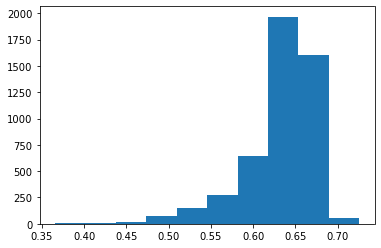

In [495]:
plt.hist(final_score[:,1])

In [497]:
e_temp = final_score[:, 1]
t_temp = instance_df['z']
y_temp = np.where(t_temp == 1, po[1], po[0])


In [435]:
ate_hat_temp = utils.calc_ipw(y_temp, t_temp, e_temp)

In [436]:
utils.generate_calib_error_df(
    t_temp,
    e_temp,
    id_,
    type_='rf_cv',
    scale='rf_cv_model'
)

,count,mean,std,min,10%,50%,90%,max,brier,type,scale,calibration_type
4_2,4802.0,0.122127,0.027313,0.000564,0.085268,0.134077,0.138429,0.156526,0.215541,rf_cv,rf_cv_model,None


In [437]:
ate_hat_temp

5.734891632924311

In [438]:
ate

4.928752399143661

In [439]:
e_calib_temp = utils.sigmoid_calib(e_temp, t_temp)

utils.calc_ipw(y_temp, t_temp, e_calib_temp)

5.71264408762999

In [440]:
utils.generate_calib_error_df(
    t_temp,
    e_calib_temp,
    id_,
    type_='rf_cv',
    scale='rf_cv_model'
)

,count,mean,std,min,10%,50%,90%,max,brier,type,scale,calibration_type
4_2,4802.0,0.12277,0.02561,0.000788,0.090577,0.133201,0.140659,0.143968,0.215476,rf_cv,rf_cv_model,None


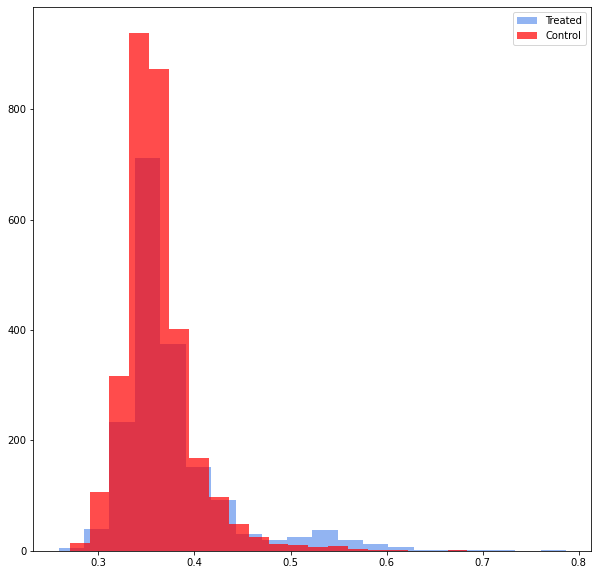

In [312]:
utils.plot_overlap(instance_df['z'], final_score[:, 1])

In [508]:
from causallib.evaluation.weight_evaluator import calculate_covariate_balance
smd = calculate_covariate_balance(x_acic, t_temp.reset_index(drop=True), pd.Series(e_temp), metric="abs_smd")

smd['weighted'].max()

abs_smd,weighted,unweighted
covariate,,
x_1,0.044346,0.046221
x_3,0.003796,0.005509
x_4,0.016661,0.016253
x_5,0.005809,0.003873
x_6,0.032528,0.035059
...,...,...
x_21_P,0.028763,0.029351
x_24_B,0.061930,0.069531
x_24_C,0.004188,0.004321


In [685]:
df_42_nested_sig.to_csv('final_42_df.csv')

In [502]:
x_acic.shape

(4802, 79)

In [505]:
e_temp

array([0.63976923, 0.58981398, 0.65459509, ..., 0.52561798, 0.42208944,
       0.63321225])

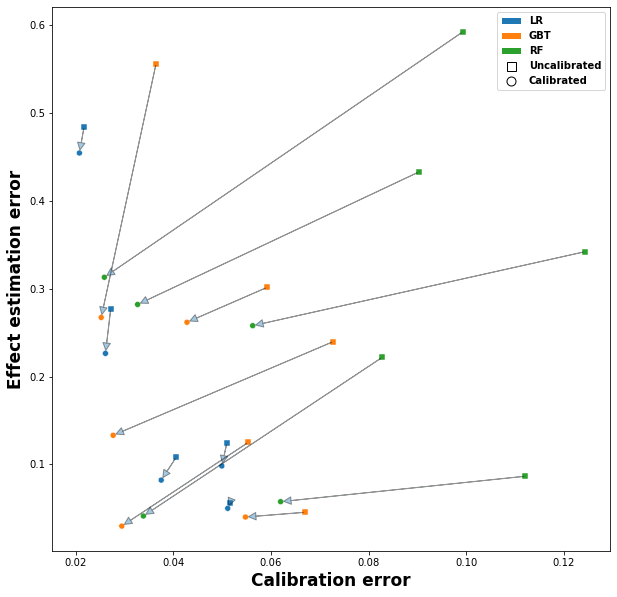

In [991]:
plot_comp_plot(df_42_nested_sig.query("scale != 'identity_model'"), metric='mean')

plt.savefig('calib_ate_acic.jpg', dpi=400)
# a.get_patches()

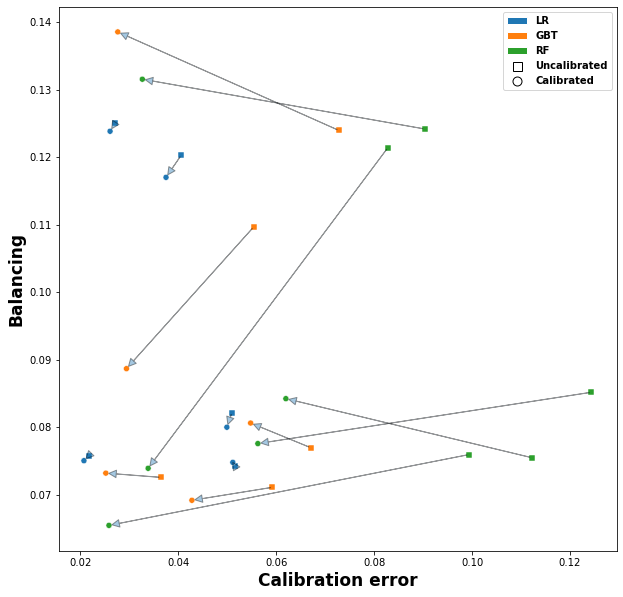

In [992]:
plot_comp_plot(df_42_nested_sig.query("scale != 'identity_model'"), metric='mean', y_metric='Balancing', y_label='Balancing')

plt.savefig('calib_balancing_acic.jpg', dpi=400)


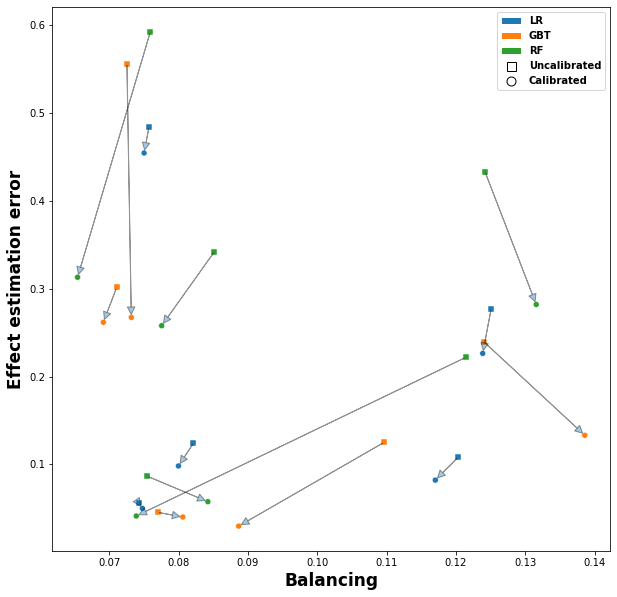

In [993]:
plot_comp_plot(df_42_nested_sig.query("scale != 'identity_model'"), metric='Balancing', x_label='Balancing')

plt.savefig('balancing_ate_acic.jpg', dpi=400)


In [1080]:
run_types = {'Nested': 'new_sig', 
             'Non-Nested': 'sig'
            }


for name, suffix in run_types.items():
    print(f'For {name} run:')
    for i in range(1,6):
        with open(f'models_test/acic42_{i}_{suffix}.pkl', 'rb') as file:
            new_res = pickle.load(file)
        t_inner_temp = new_res['t']
        models_inner = new_res['models']['GBT_cv_model']
        print(f'\t{i}: Uncalibrated: {roc_auc_score(t_inner_temp, models_inner["uncalibrated"]):.2%}, Callibrated: {roc_auc_score(t_inner_temp, models_inner["calibrated"]):.2%}')

For Nested run:
	1: Uncalibrated: 54.79%, Callibrated: 54.79%
	2: Uncalibrated: 57.24%, Callibrated: 57.24%
	3: Uncalibrated: 57.14%, Callibrated: 57.14%
	4: Uncalibrated: 50.55%, Callibrated: 50.55%
	5: Uncalibrated: 52.63%, Callibrated: 52.63%
For Non-Nested run:
	1: Uncalibrated: 59.96%, Callibrated: 59.96%
	2: Uncalibrated: 61.51%, Callibrated: 61.51%
	3: Uncalibrated: 66.82%, Callibrated: 66.82%
	4: Uncalibrated: 54.12%, Callibrated: 54.12%
	5: Uncalibrated: 57.94%, Callibrated: 57.94%


In [1071]:
with open('models_test/acic42_1_new_sig.pkl', 'rb') as file:
    new_res = pickle.load(file)
    

roc_auc_score(new_res['t'], new_res['models']['GBT_cv_model']['uncalibrated'])
roc_auc_score(new_res['t'], new_res['models']['GBT_cv_model']['calibrated'])

In [1073]:
from sklearn.metrics import roc_auc_score

roc_auc_score(new_res['t'], new_res['models']['GBT_cv_model']['uncalibrated'])

0.5478993261062479

In [1066]:
with open('models_test/acic42_1_sig.pkl', 'rb') as file:
    new_res = pickle.load(file)

{'t': 0       0
 1       1
 2       0
 3       1
 4       1
        ..
 4797    0
 4798    0
 4799    1
 4800    1
 4801    1
 Name: z, Length: 4802, dtype: int64,
 'prop': 0       0.686039
 1       0.672264
 2       0.655583
 3       0.637635
 4       0.628436
           ...   
 4797    0.675788
 4798    0.677884
 4799    0.709761
 4800    0.699837
 4801    0.647685
 Name: e, Length: 4802, dtype: float64,
 'models': {'lr_model': {'uncalibrated': array([0.67449943, 0.61747775, 0.64984876, ..., 0.66013559, 0.58485815,
          0.71046885]),
   'calibrated': array([0.66985836, 0.64592269, 0.65960985, ..., 0.66390546, 0.63188435,
          0.68452576])},
  'lr_l1_model': {'uncalibrated': array([0.6201164 , 0.63242533, 0.65818427, ..., 0.64687341, 0.62475301,
          0.71687746]),
   'calibrated': array([0.65116403, 0.65576764, 0.66530681, ..., 0.66113418, 0.65290152,
          0.68653592])},
  'lr_l2_model': {'uncalibrated': array([0.64905611, 0.62097485, 0.63956713, ..., 0.65033524, 0